In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
# from matplotlib.colors import LogNorm
import numpy as np
import math as ma
from subprocess import call

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from scipy.io import readsav
from scipy.interpolate import interp1d
# from scipy.interpolate import interp2d

import extinction
import igm

import loadSP as lsp
import cosmo
import halos
# import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [3]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449, name='myCosmo')
# Make sure we have halo information for this z... hop/...
num = 43 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
z   = 12.0

print("Using astropy cosmology: physical size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))

sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Physical Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))
boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1]

rho_critDMz = myCosmo.critical_density(z) * myCosmo.Odm(z)
print('rho_critdm,z = {:.3e}'.format(rho_critDMz))

gc.collect()

Using astropy cosmology: physical size 325.03 kpc
Physical Boxsize from kKey file = 324.44 kpc
rho_critdm,z = 4.621e-27 g / cm3


72

In [4]:
Odm = 0.222 # Om - Ob = Odm
h0  = 0.71
rho0 = myCosmo.critical_density0 * Odm # rho0 * O_DM --- Crit density in DM TODAY... Need to scale to redshift.
rho0/Odm
# Looks correct!

<Quantity 9.469372730554712e-30 g / cm3>

In [5]:
dmPartMass = 5.58e4 * Odm / h0 * u.Msun
print("DM particle mass {:.2f}".format(dmPartMass))
def totMass(numParts):
    return dmPartMass * numParts

DM particle mass 17447.32 solMass


In [6]:
# Example computation... 
haloTotMass = dmPartMass * 50863 # Halo 0, z=12
overDens = 100.0
size = ((haloTotMass * 3.0/(4.0 * ma.pi) * 1.0/(rho_critDMz * overDens))**(1.0/3.0)).to(u.kpc) * (1 + z)
# size = size * 0.5
size

<Quantity 40.85630933965904 kpc>

In [7]:
locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z)
##############################################
# Need to correct the Z and PZ for the pristine
# fraction of the SP... 
##############################################
fpol = 1.0-PPF
fpol[fpol < 1e-5] = 0.0 # Don't form polluted stars when fpol is very small

Z_corr = Z/fpol
Z_corr[np.isinf(Z_corr)] = 0.9e-5 # Make the Z of the particles < Z_crit (1e-5)
Z_corr[Z_corr < 1e-5]    = 0.9e-5 # Place them all just below Z_crit
gc.collect()

/Users/earnric/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in divide


36

In [15]:
locs = (locsRaw/boxsizekpc) * 3000.0/h0 # Comoving coords of SPs 

In [16]:
# Compute age of the star particles...
# spAges is in Myr ... 

baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
print("base age {:.2f}".format(baseAge))
spAges = baseAge - bt/1e6    # bt from SP file is in yr, convert to Myr... 
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))
print("max sp Z {:.2e} mass frac".format(max(Z) * 0.02))

base age 378.32
min sp age 0.30 Myr
max sp age 179.21 Myr
min sp Z 5.00e-09 Solar
max sp Z 1.13e-01 Solar
max sp Z 2.25e-03 mass frac


In [17]:
arcPerKpc = myCosmo.arcsec_per_kpc_comoving(z=z)
print('Comoving @ {}, {:.4f}:'.format(z,arcPerKpc))
arcPerKpc = myCosmo.arcsec_per_kpc_proper(z=z)
print('Proper @ {}, {:.4f}:'.format(z,arcPerKpc))
print('Proper @ {}, {:.4f}:'.format(z,1/arcPerKpc))

kpcPerArcSec = cosmo.arcAtz(71,z=z,om=0.267) # size of an arcsec at the specified reshift in kpc
print('My Comoving @ {}, {:.4f}:'.format(z,arcPerKpc/(1+z)))
print('My Proper @ {}, {:.4f}:'.format(z,arcPerKpc))
print('My Proper @ {}, {:.4f}:'.format(z,1/arcPerKpc))

Comoving @ 12.0, 0.0204 arcsec / kpc:
Proper @ 12.0, 0.2657 arcsec / kpc:
Proper @ 12.0, 3.7636 kpc / arcsec:
My Comoving @ 12.0, 0.0204 arcsec / kpc:
My Proper @ 12.0, 0.2657 arcsec / kpc:
My Proper @ 12.0, 3.7636 kpc / arcsec:


In [18]:
myCosmo.age(z)

<Quantity 0.3768910697095989 Gyr>

In [22]:
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
## Scale locations to co-moving coordates
## USING hopRick MEANS WE ARE GETTING STAR PARTICLE DETERMINED HALOS. THE NUM PARTICLES IN THESE FILES IS NOT DM ##
##
halosRawPos = lsp.loadHaloGrps(num,prefix='/Users/earnric/RAMSES-Data/27Aug15-3Mpc/27Aug15-3Mpc-output/hop/') # Returns positions normalized to (-0.5, 0.5)
halossizes = lsp.loadHaloSizes(num,prefix='/Users/earnric/RAMSES-Data/27Aug15-3Mpc/27Aug15-3Mpc-output/hop/') # Returns positions normalized to (-0.5, 0.5)

#halosPos = halosRawPos * boxsizekpc # Physical at z... 
halosPos = halosRawPos * 3000.0/h0 # Comoving box 
print("Num of halos @ {} = {}".format(z,len(halosRawPos)))

Num of halos @ 12.0 = 1224


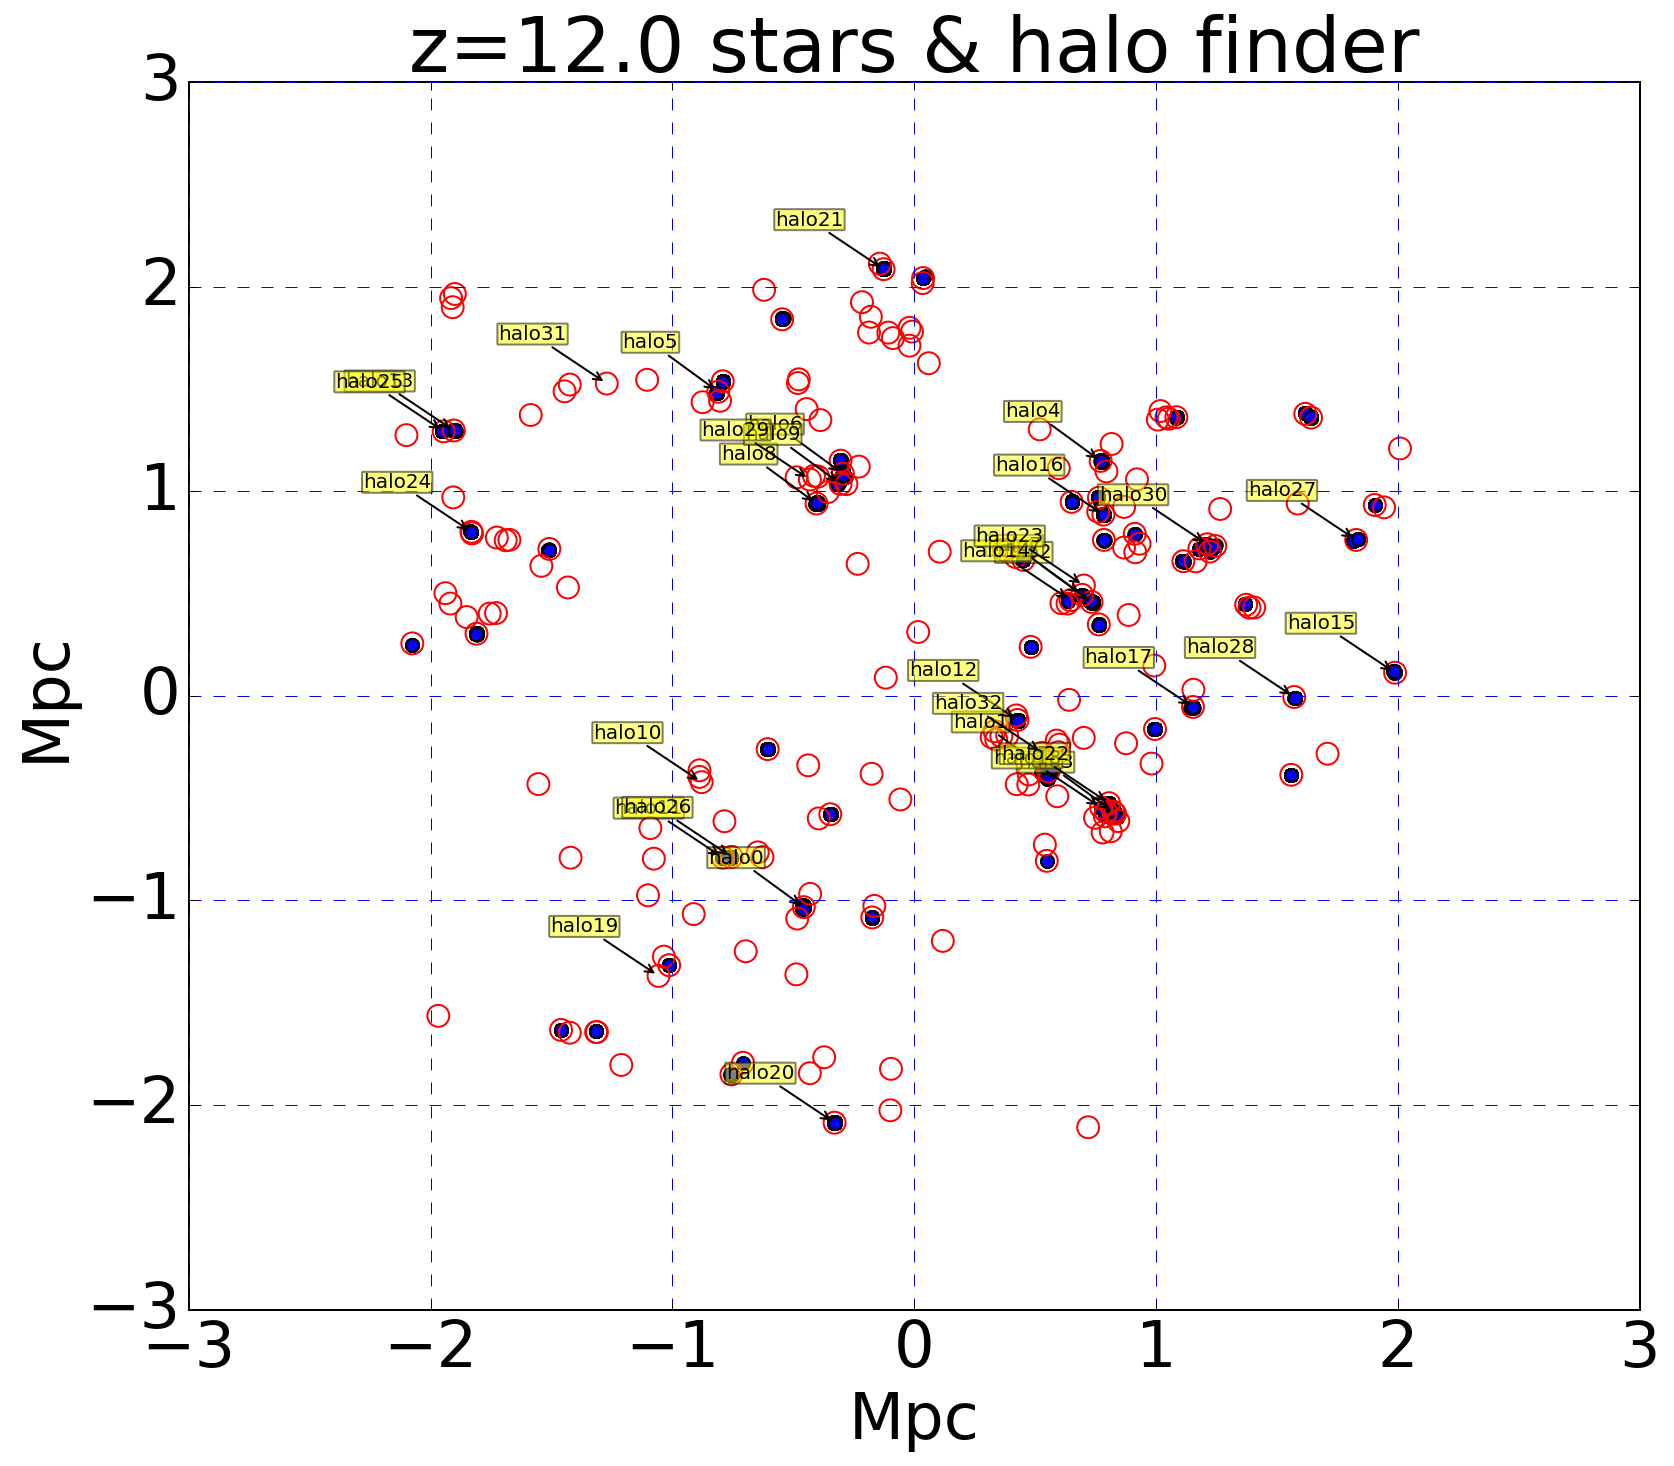

6166

In [28]:
htp = min(200,len(halosRawPos))
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0]/1000,halosPos[:htp,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc')
plt.ylabel('Mpc')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,0][:33]/1000,halosPos[:htp,1][:33]/1000):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

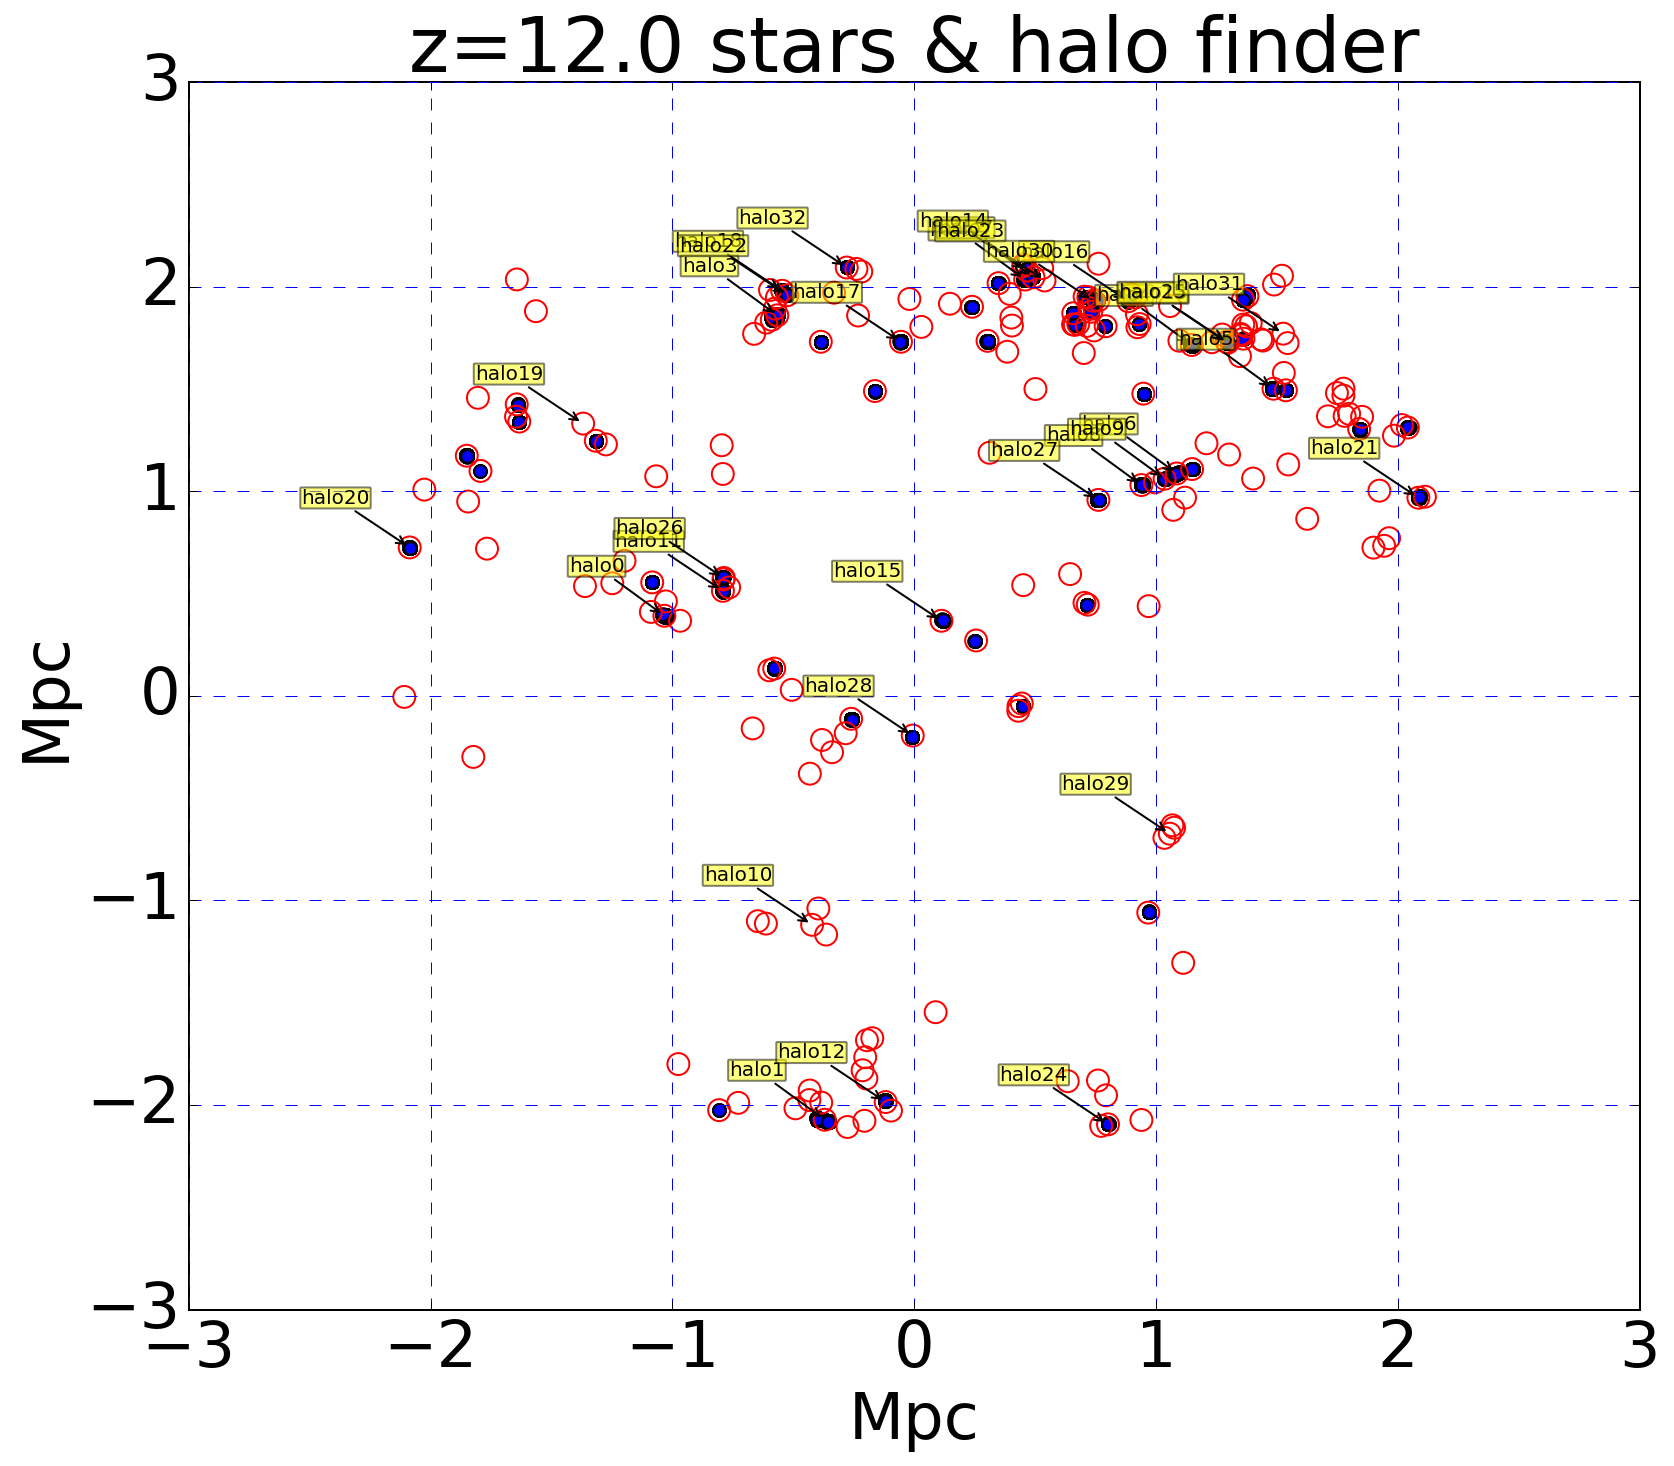

13388

In [27]:
htp = min(200,len(halosRawPos))
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,1]/1000,locs[:,2]/1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,1]/1000,halosPos[:htp,2]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc')
plt.ylabel('Mpc')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.title('z=%.1lf stars & halo finder'%z)
for label, x, y in zip(labels, halosPos[:htp,1][:33]/1000,halosPos[:htp,2][:33]/1000):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

radius 22.41
Halo mass 0 is 7.12e+06
radius 22.24
Halo mass 1 is 3.78e+06
radius 19.20
Halo mass 2 is 2.68e+06
radius 18.52
Halo mass 3 is 1.33e+06
radius 18.27
Halo mass 4 is 3.25e+06
radius 15.92
Halo mass 5 is 5.93e+05
radius 15.30
Halo mass 6 is 1.13e+06
radius 14.49
Halo mass 7 is 3.03e+05
radius 14.17
Halo mass 8 is 1.11e+06
radius 14.02
Halo mass 9 is 9.70e+05
radius 13.81
Halo mass 10 is 0.00e+00
radius 13.63
Halo mass 11 is 8.38e+05
radius 13.61
Halo mass 12 is 4.88e+05
radius 13.57
Halo mass 13 is 6.65e+05
radius 13.40
Halo mass 14 is 1.30e+05
radius 13.20
Halo mass 15 is 6.21e+05
radius 12.91
Halo mass 16 is 5.07e+05
radius 12.86
Halo mass 17 is 4.88e+05
radius 12.64
Halo mass 18 is 4.60e+05
radius 12.62
Halo mass 19 is 0.00e+00


/Users/earnric/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1084

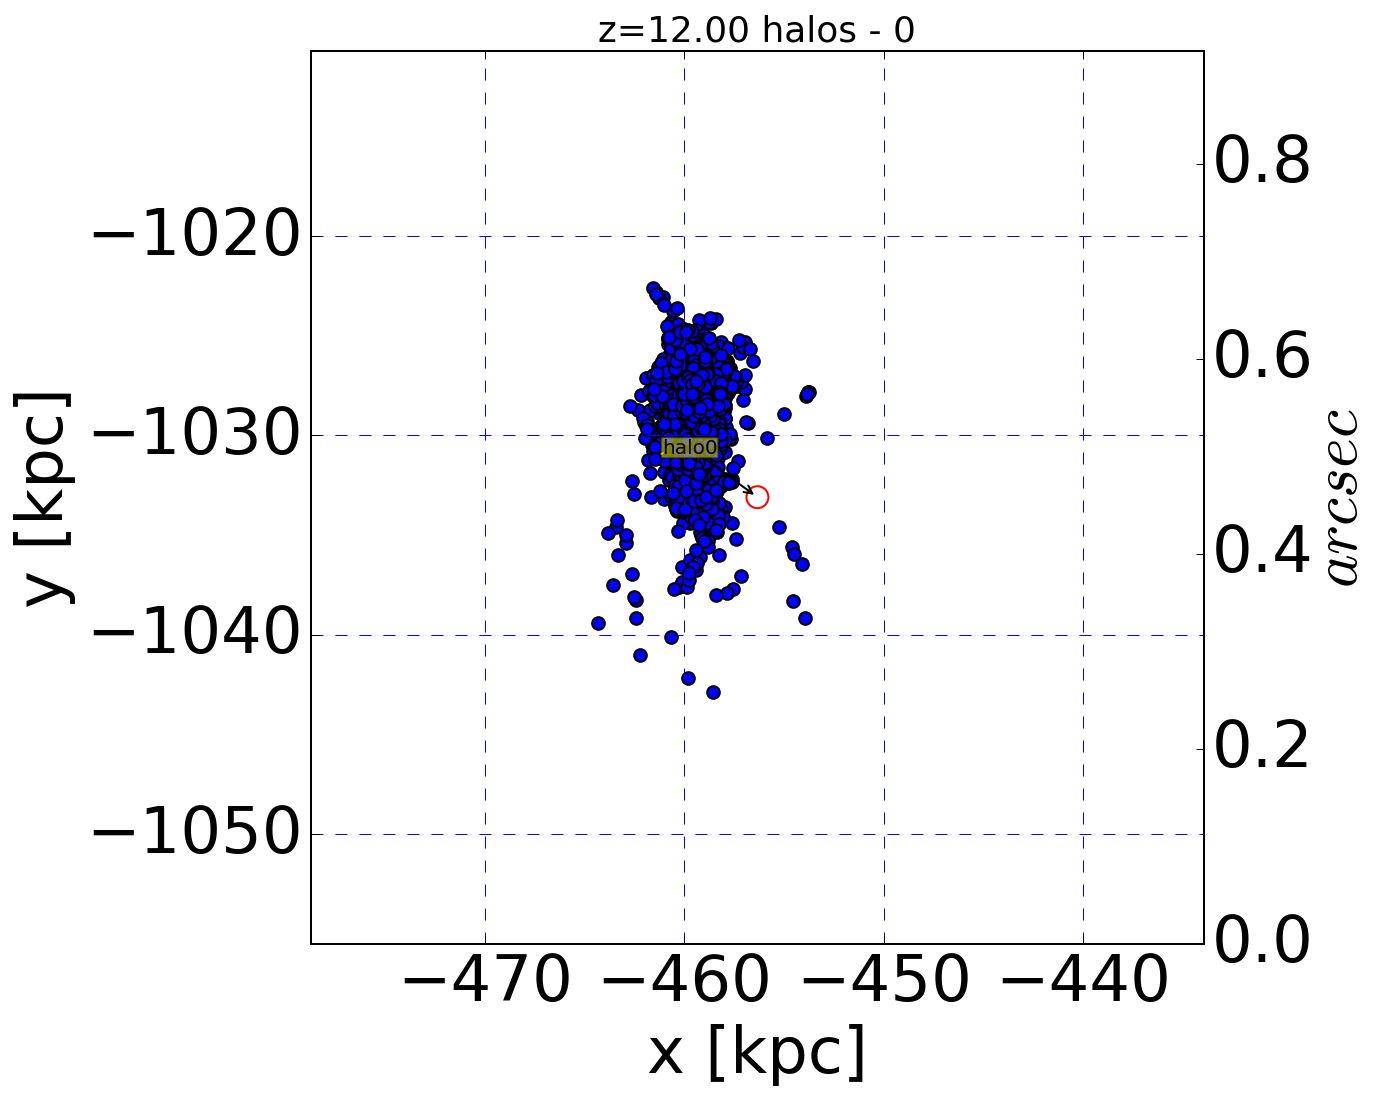

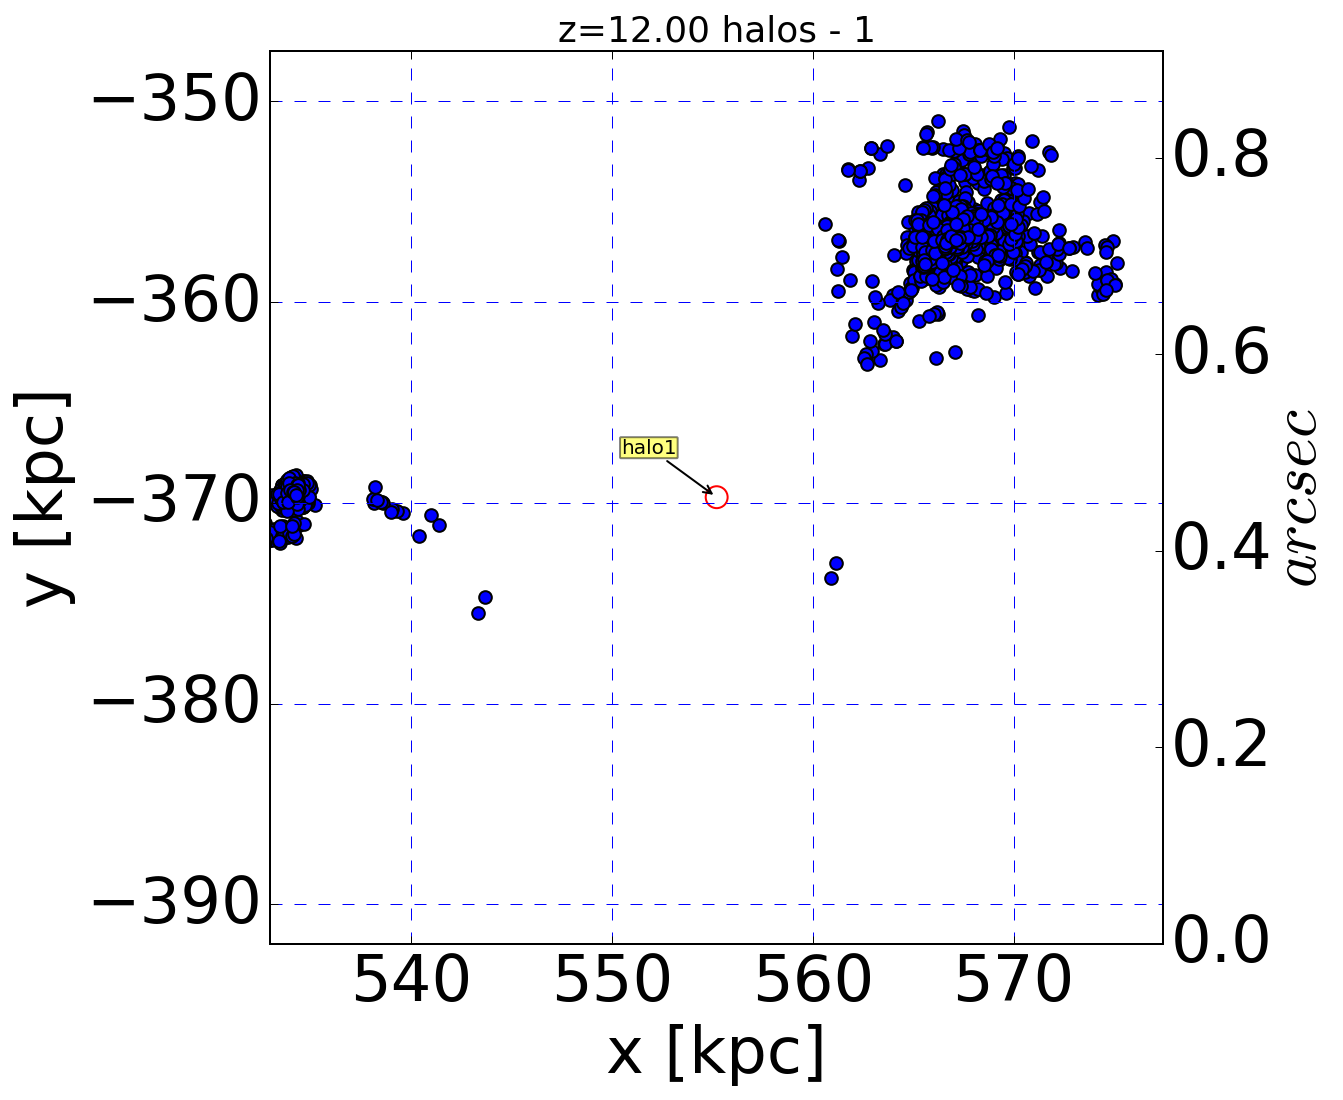

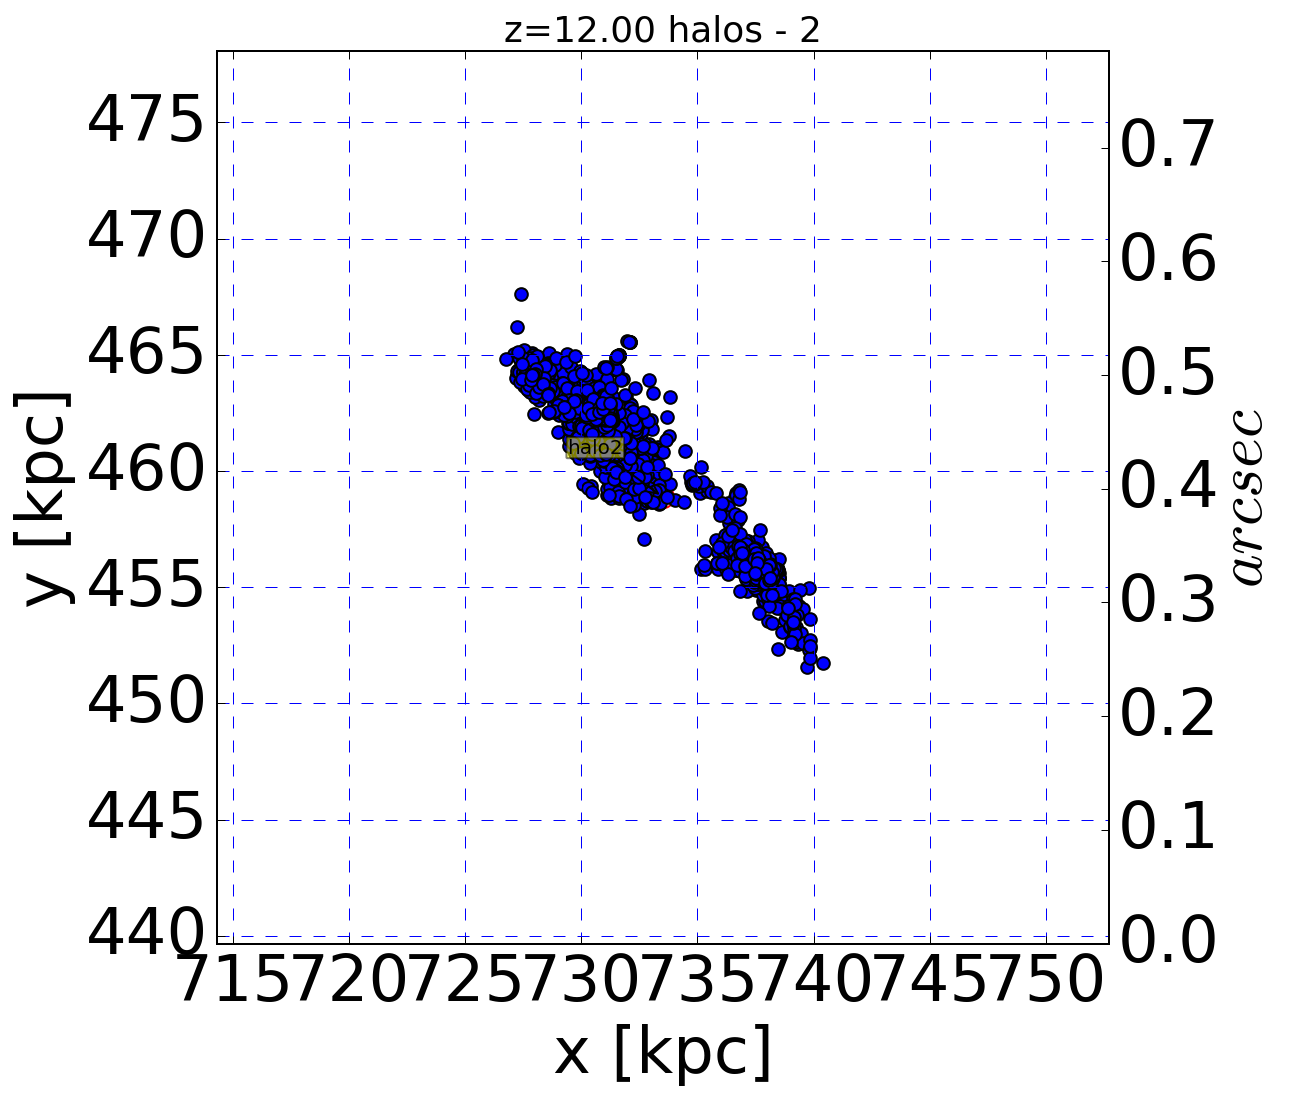

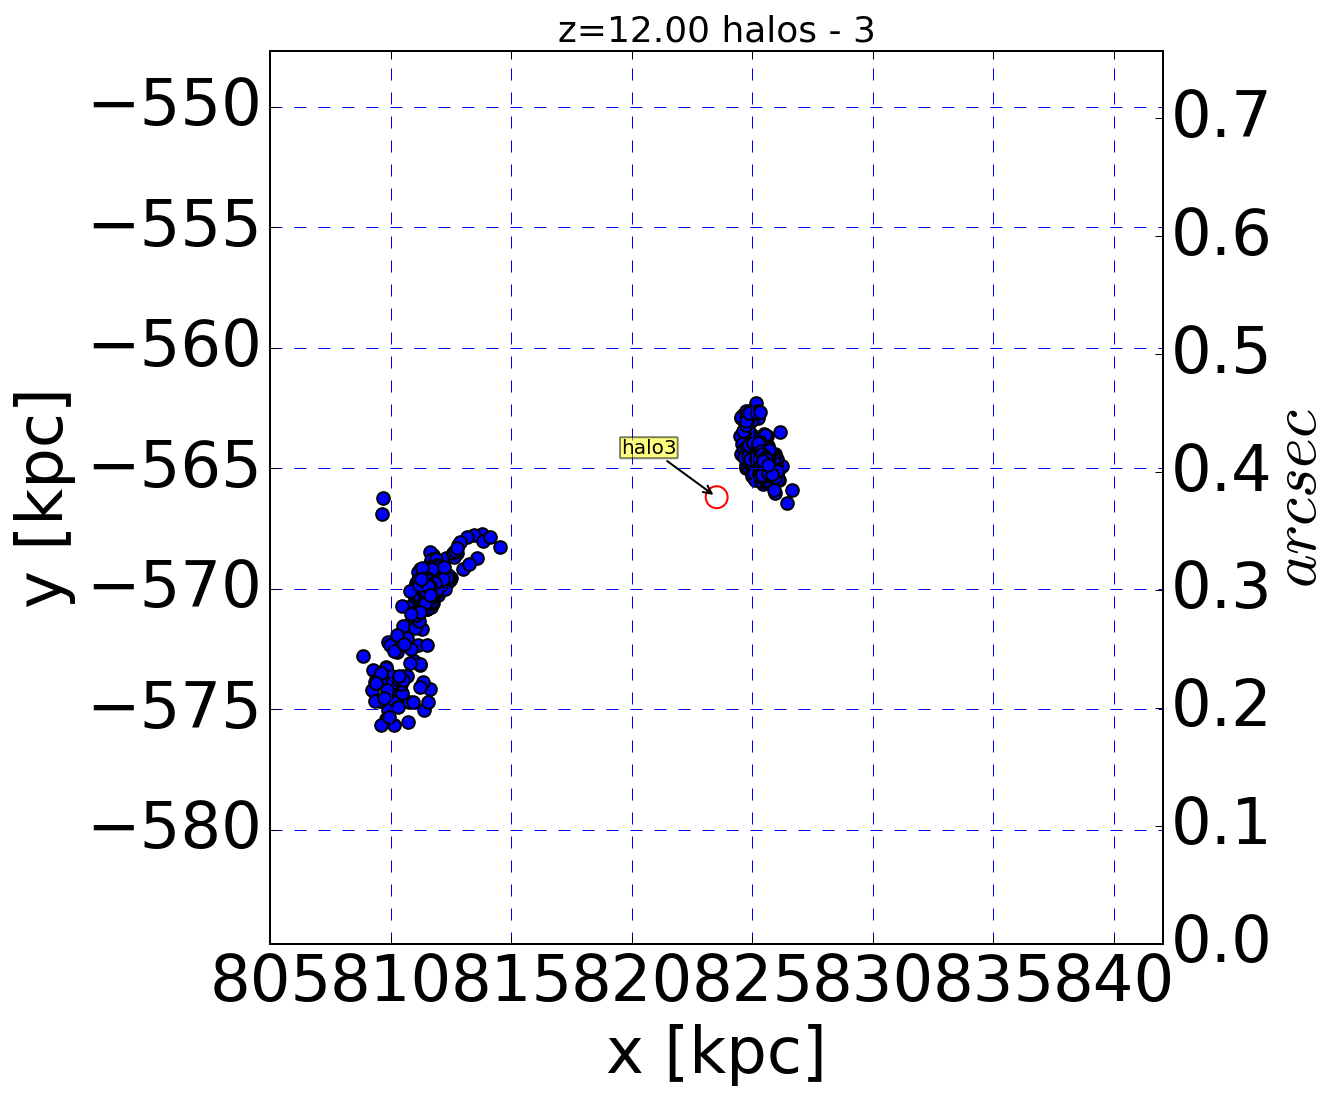

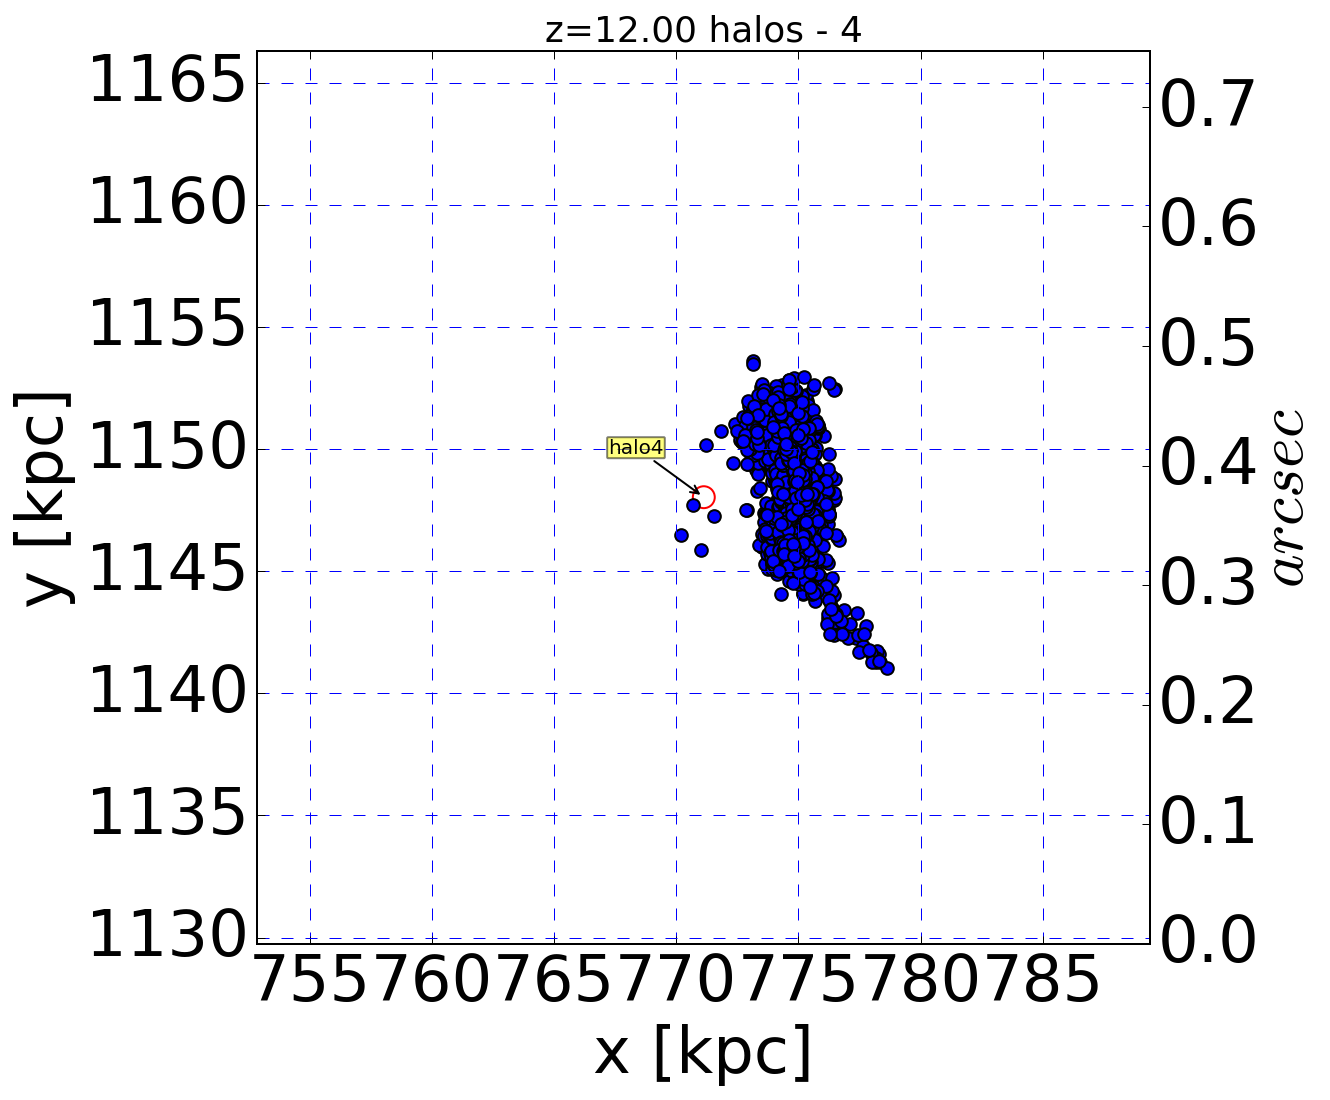

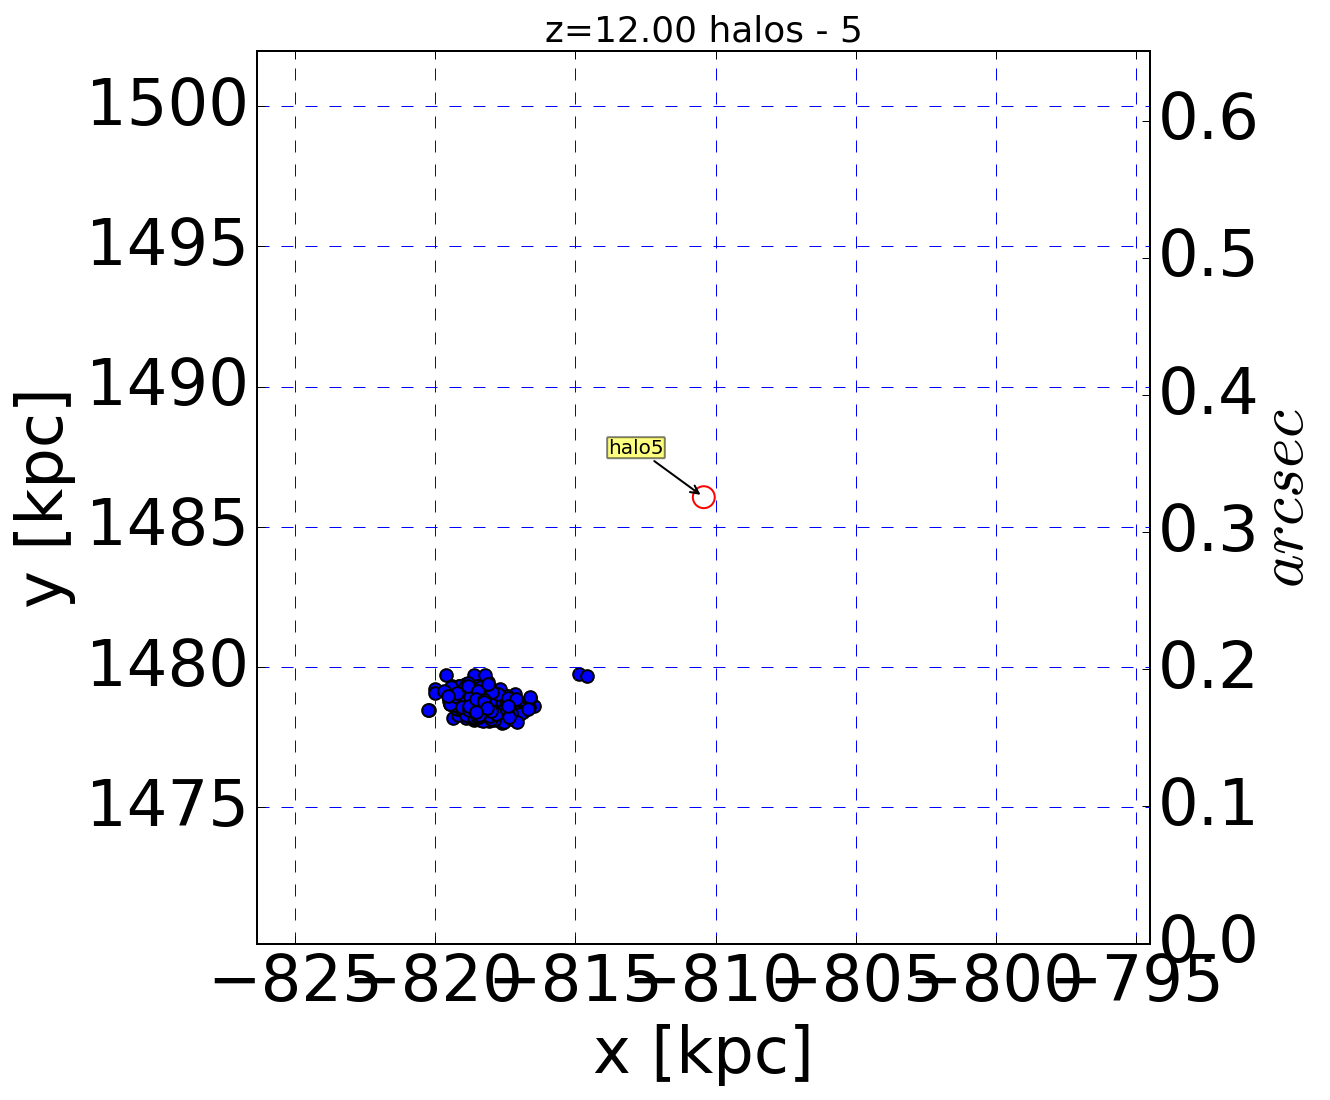

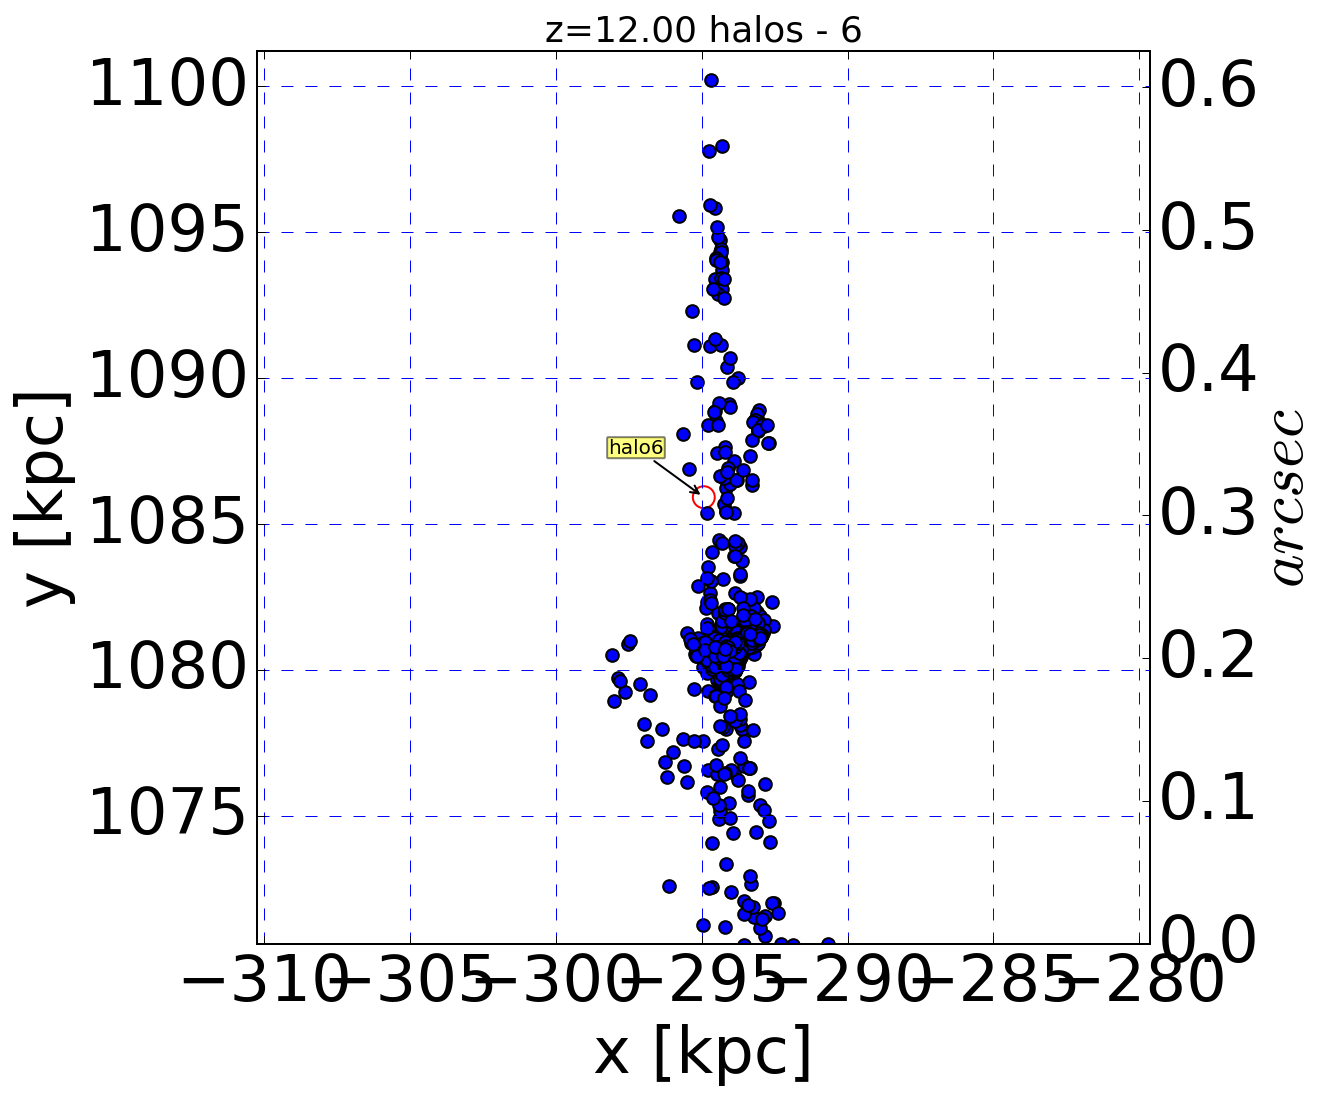

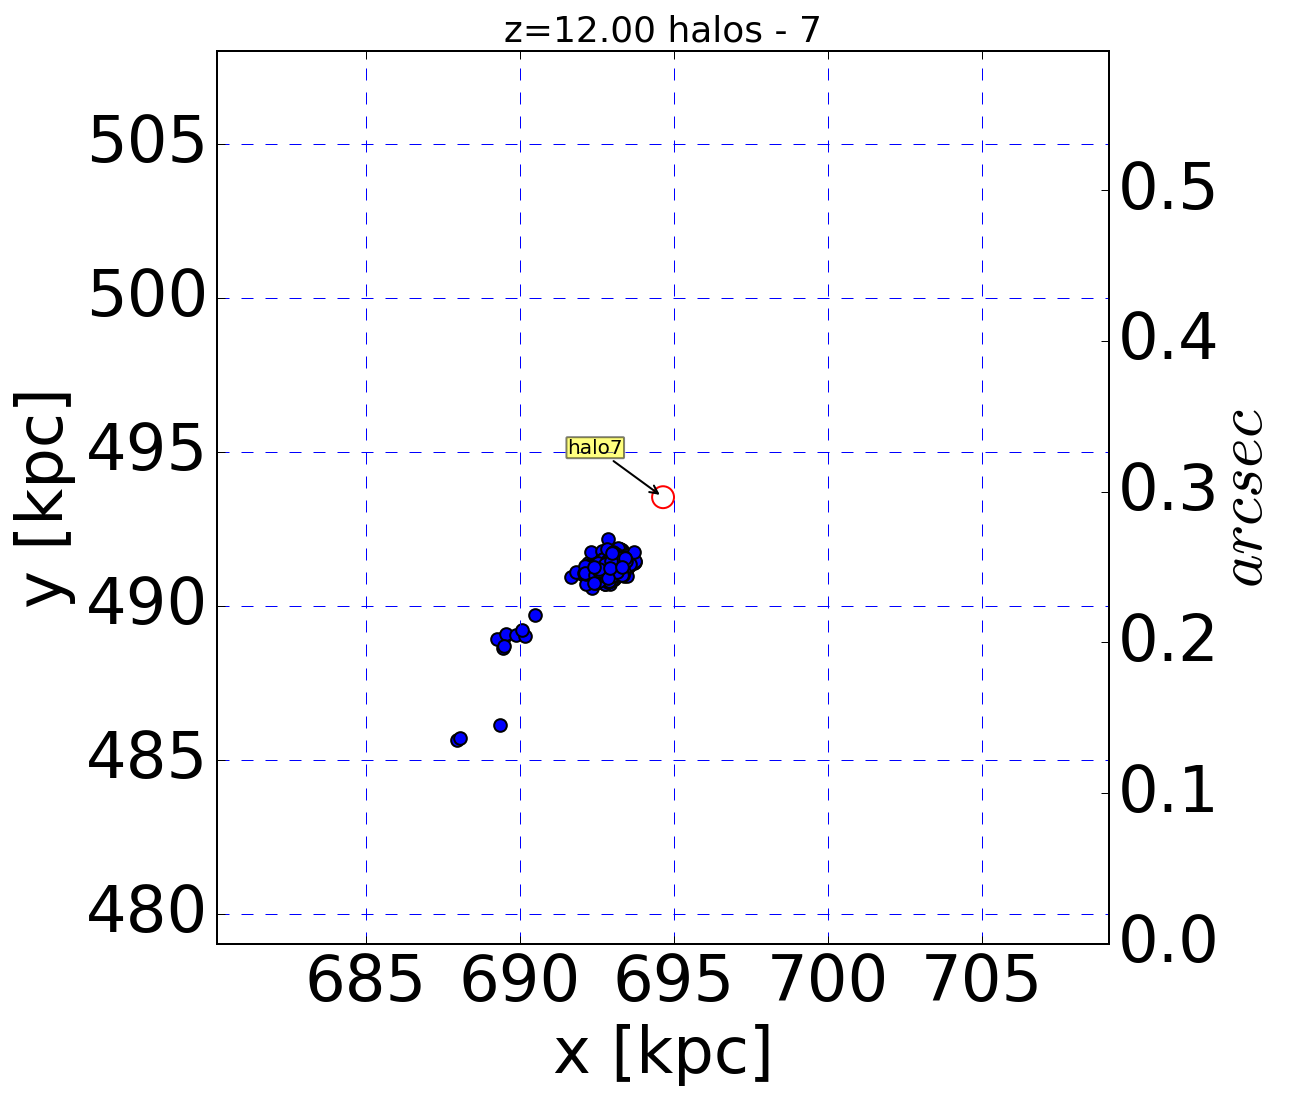

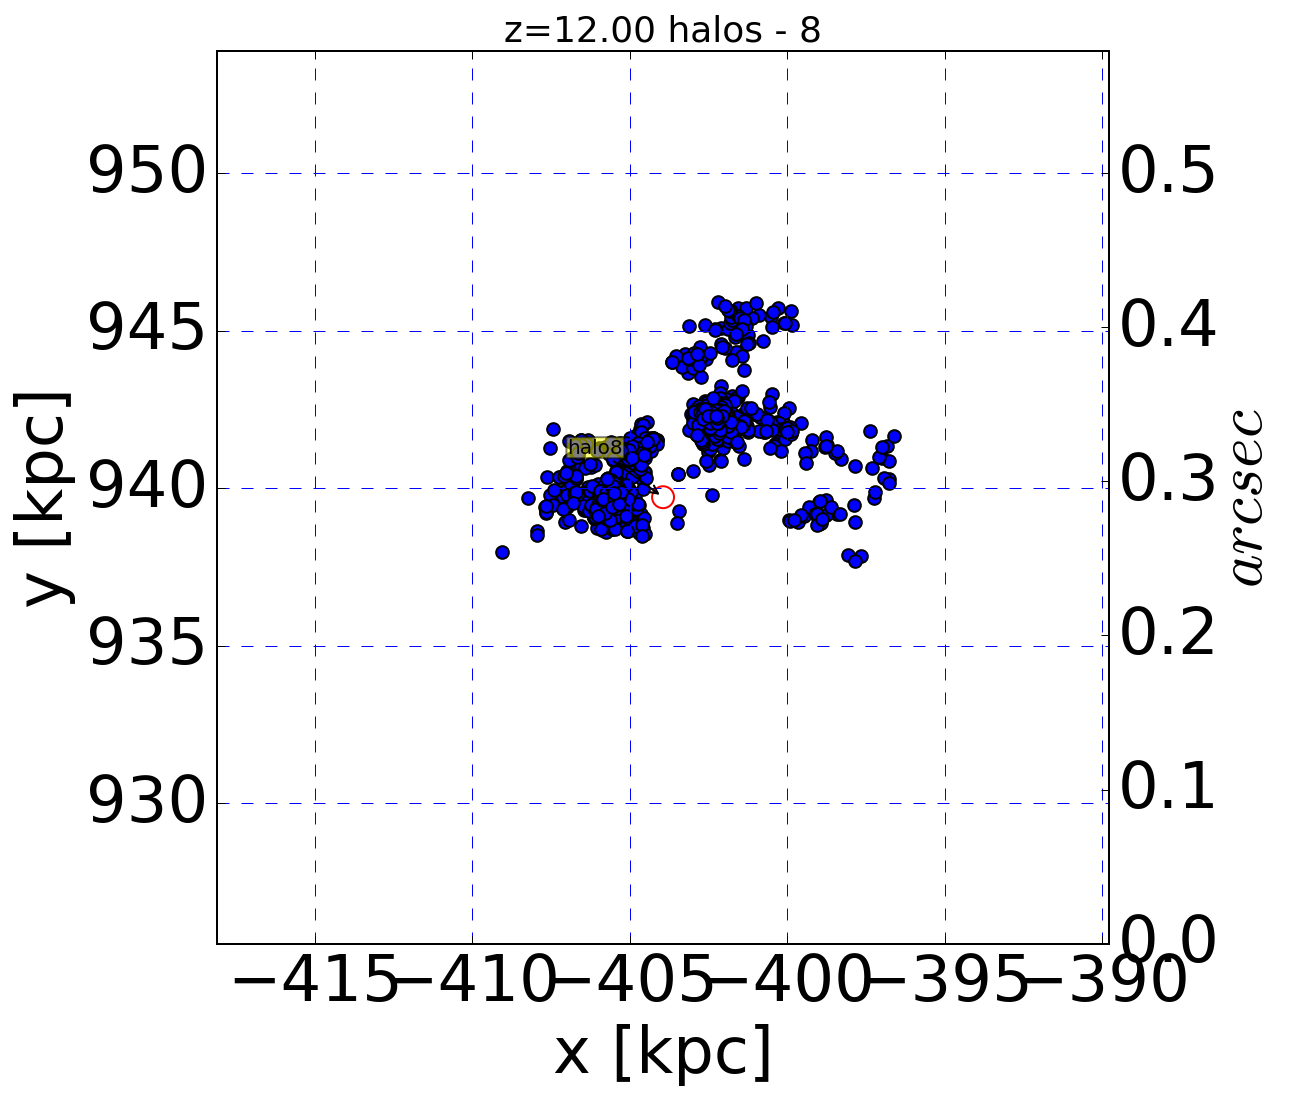

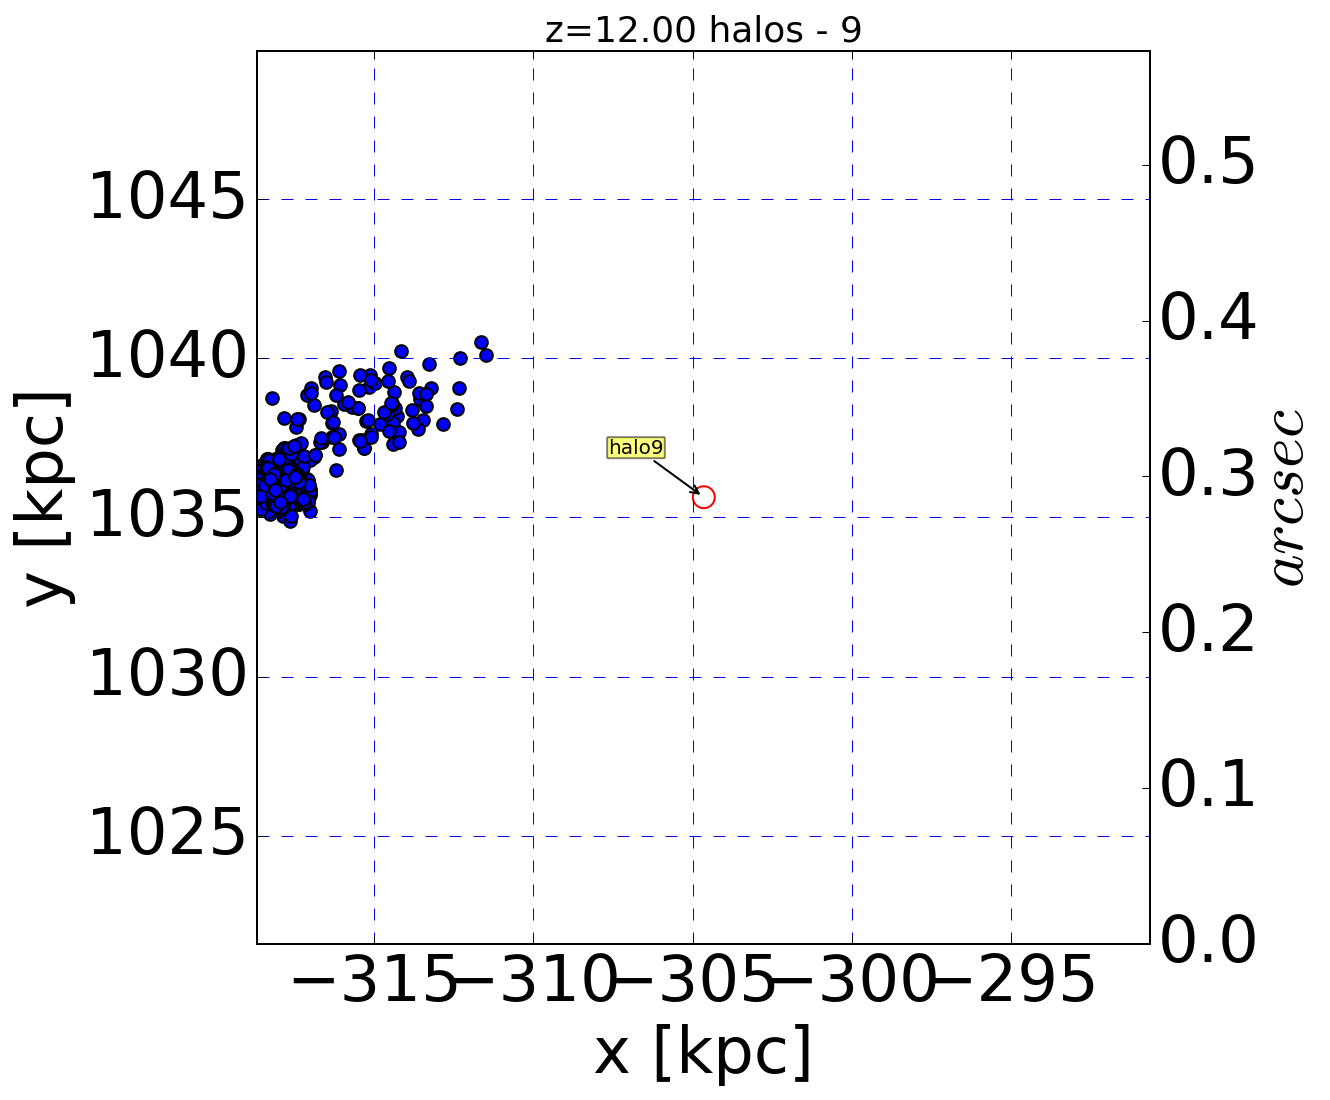

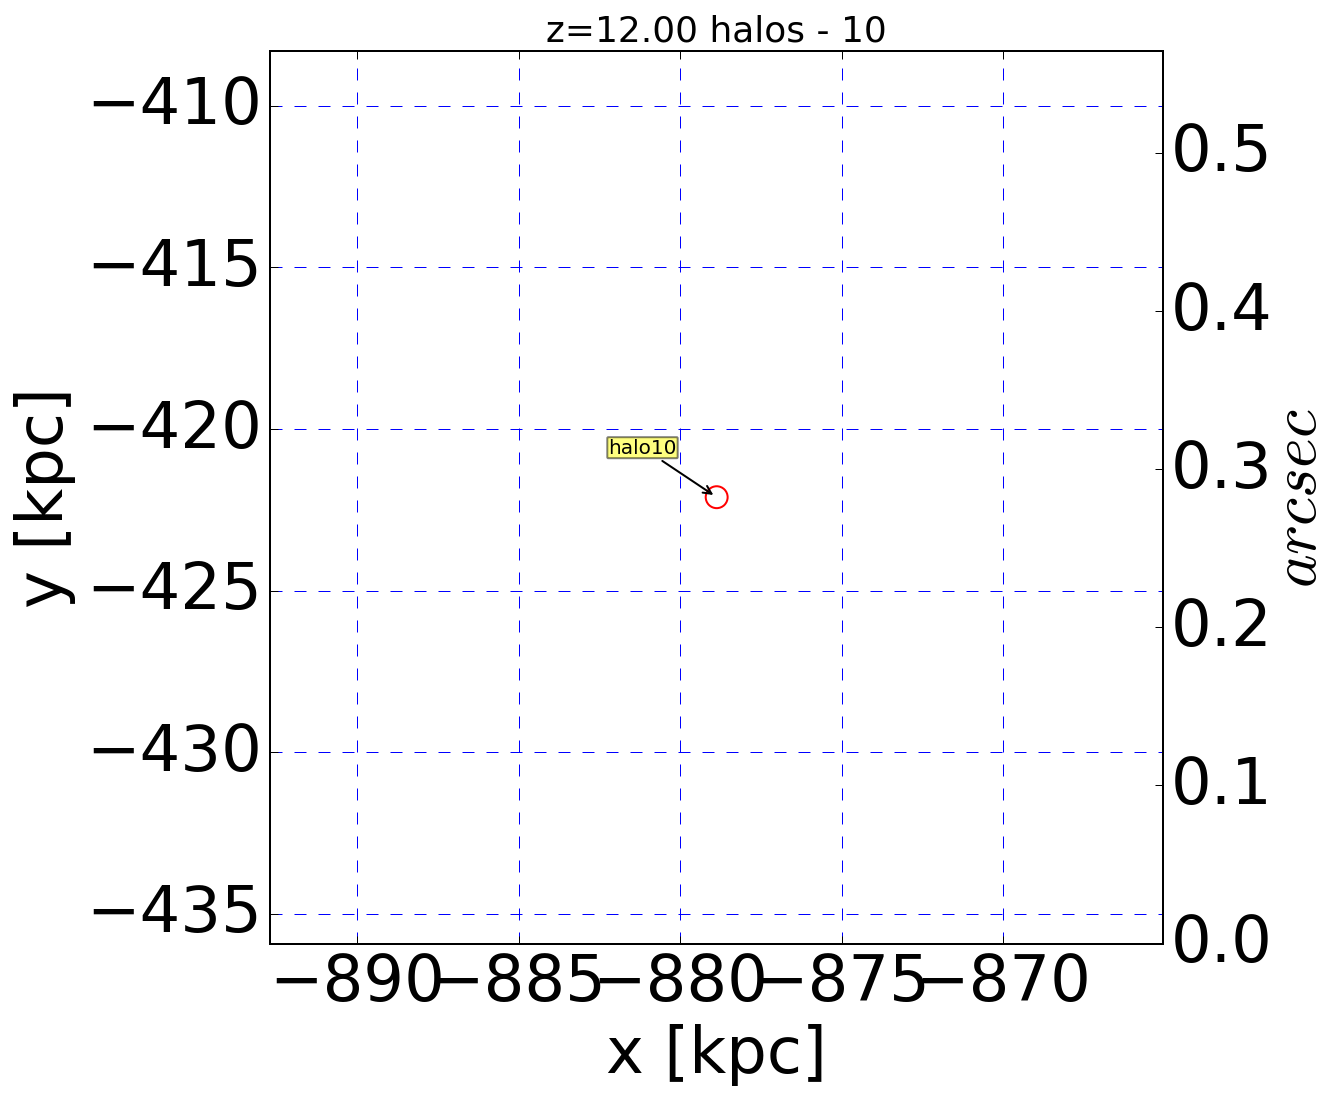

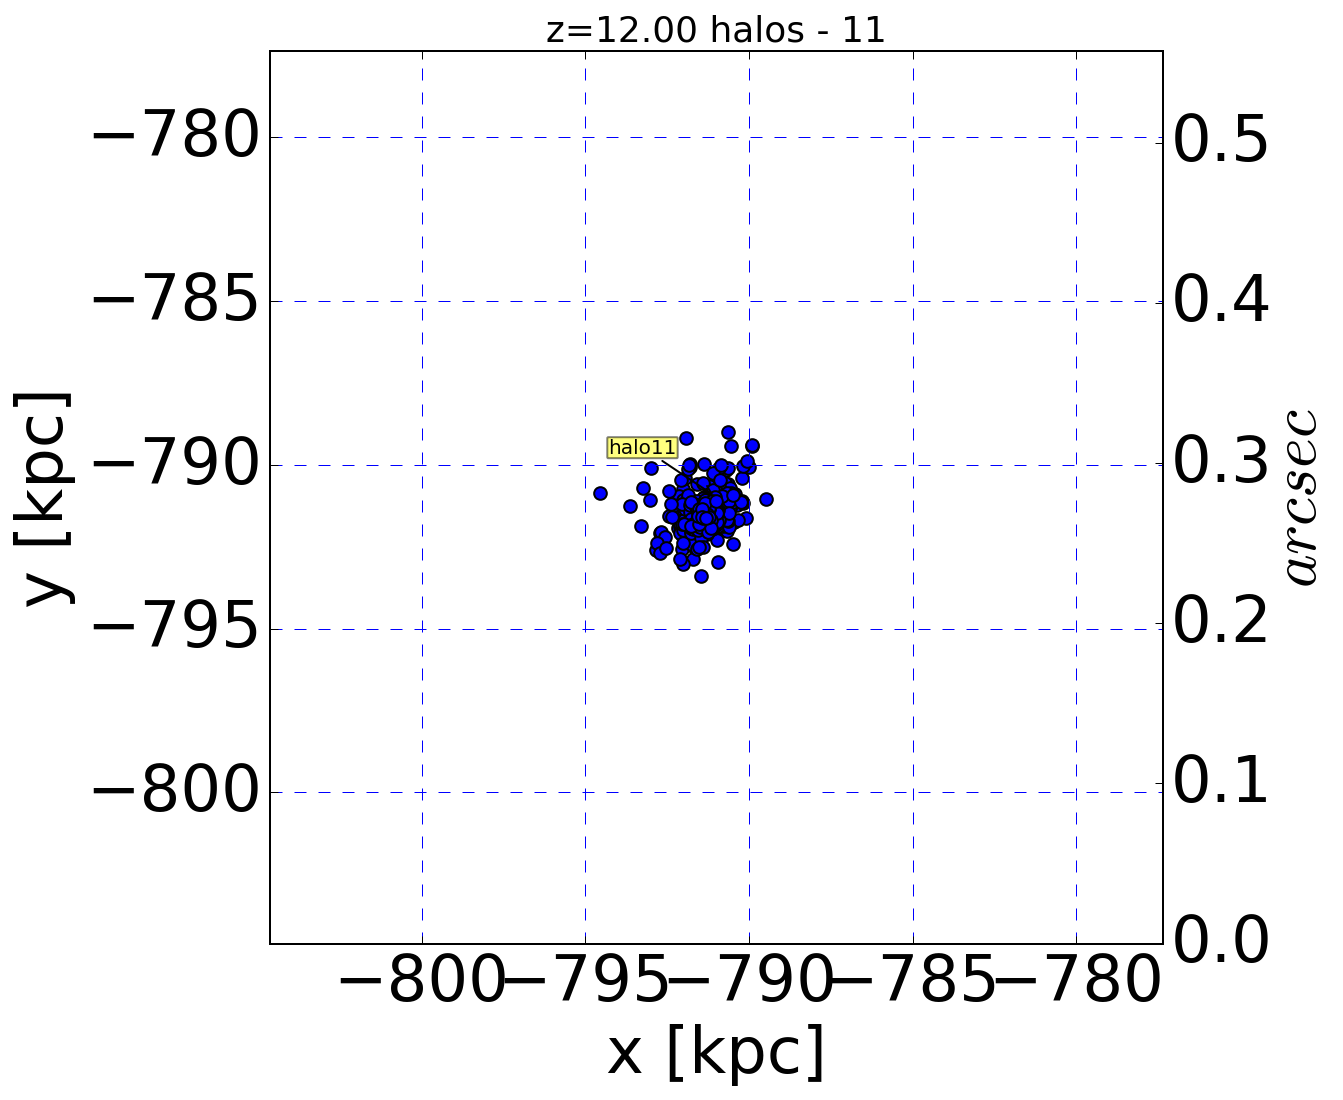

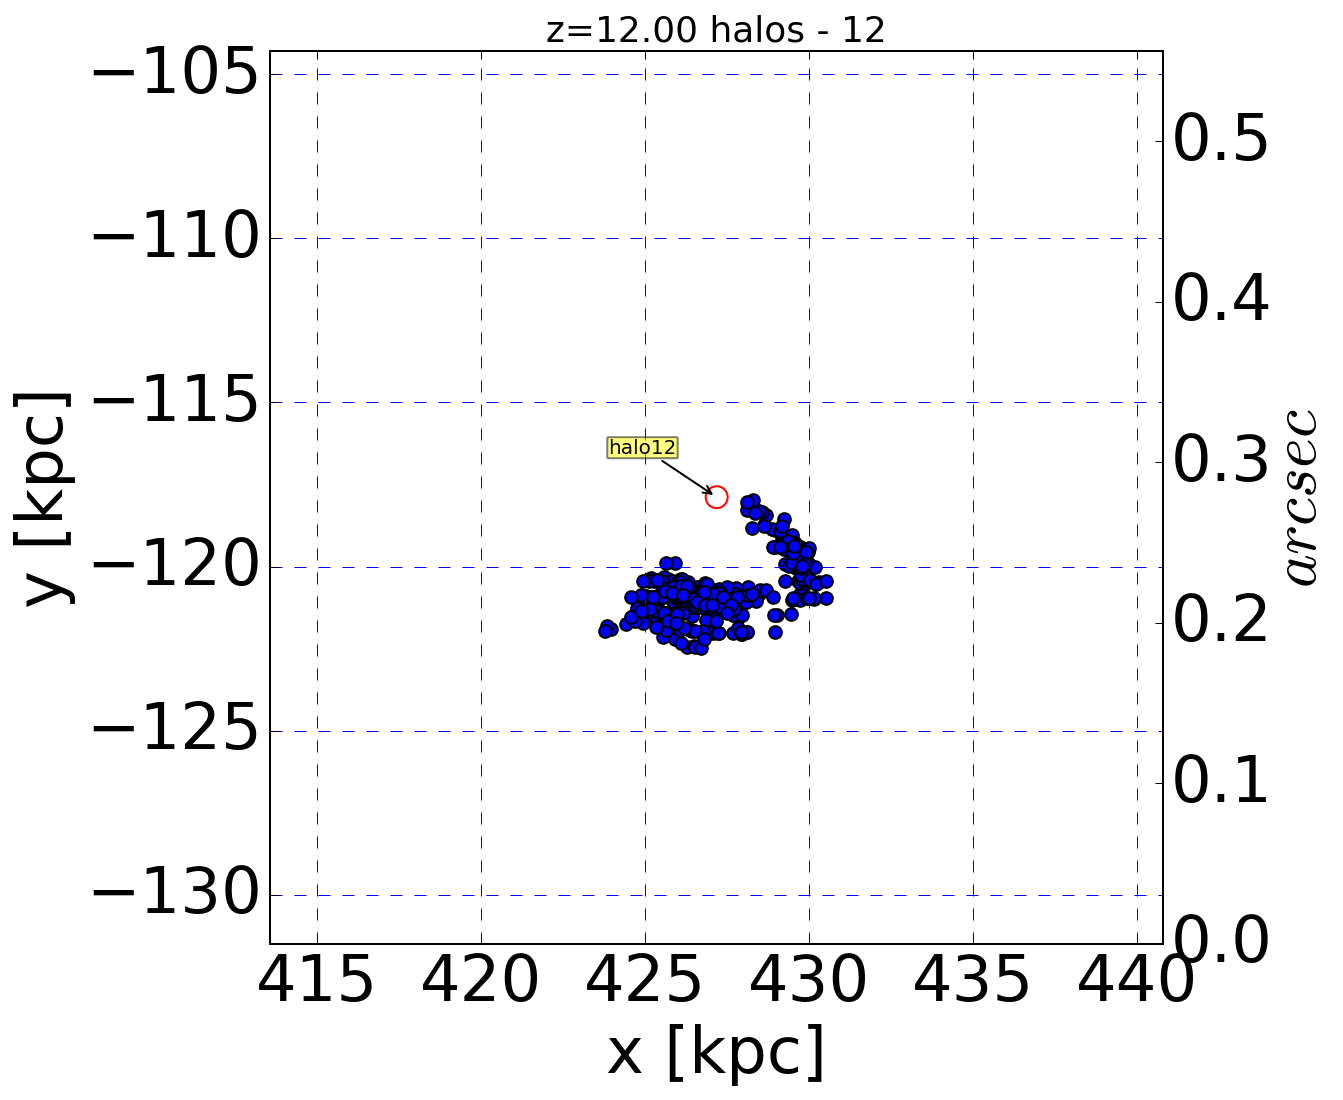

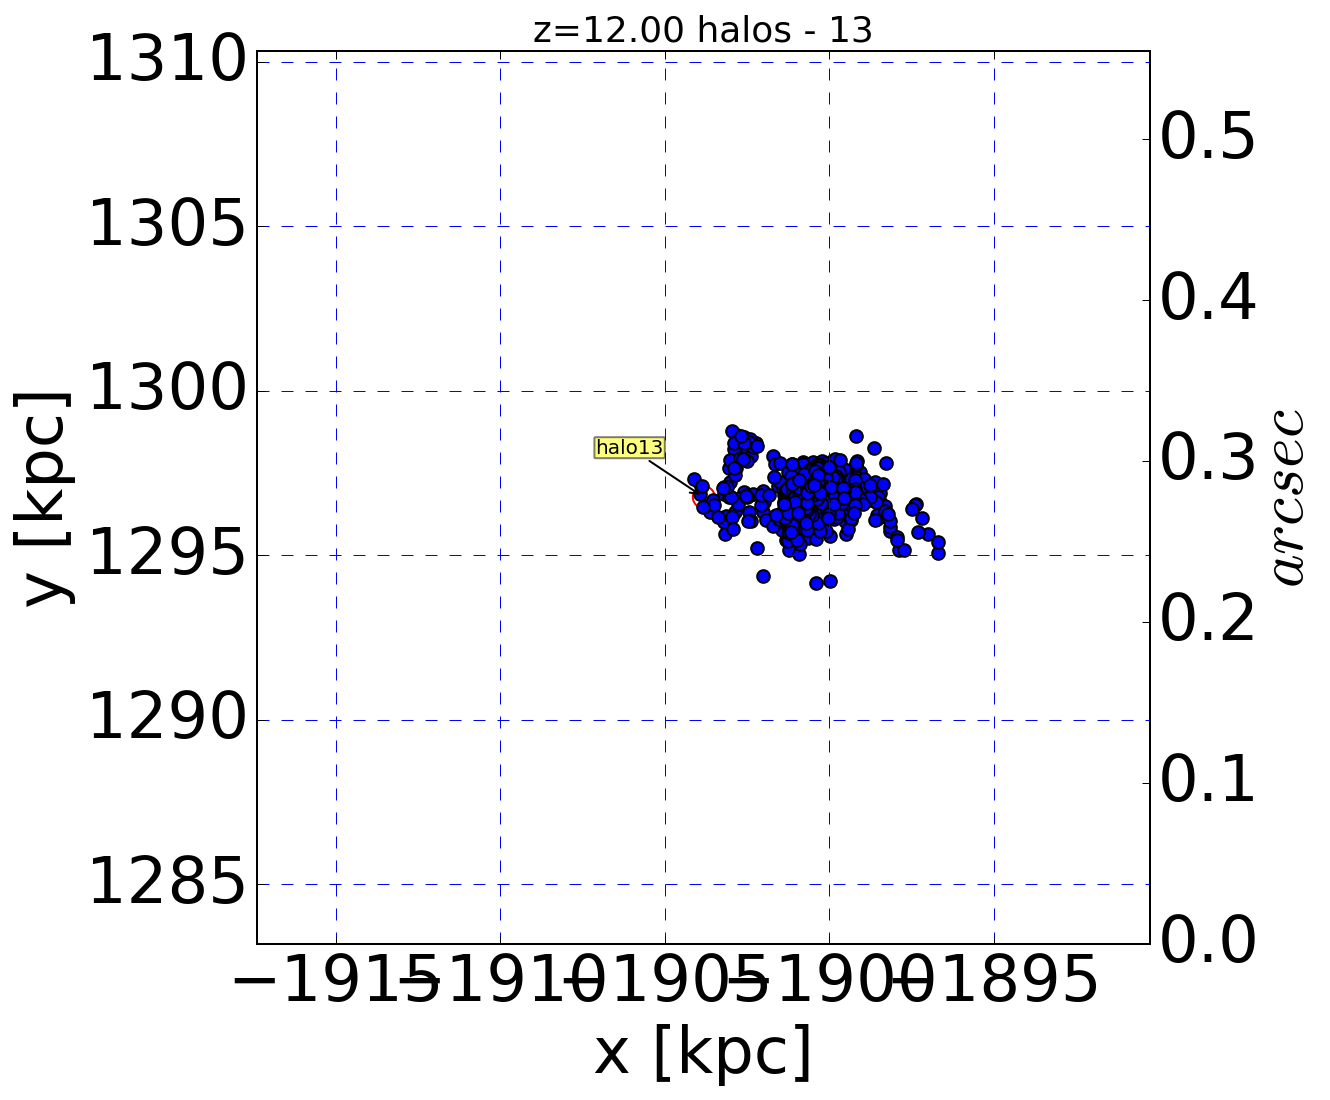

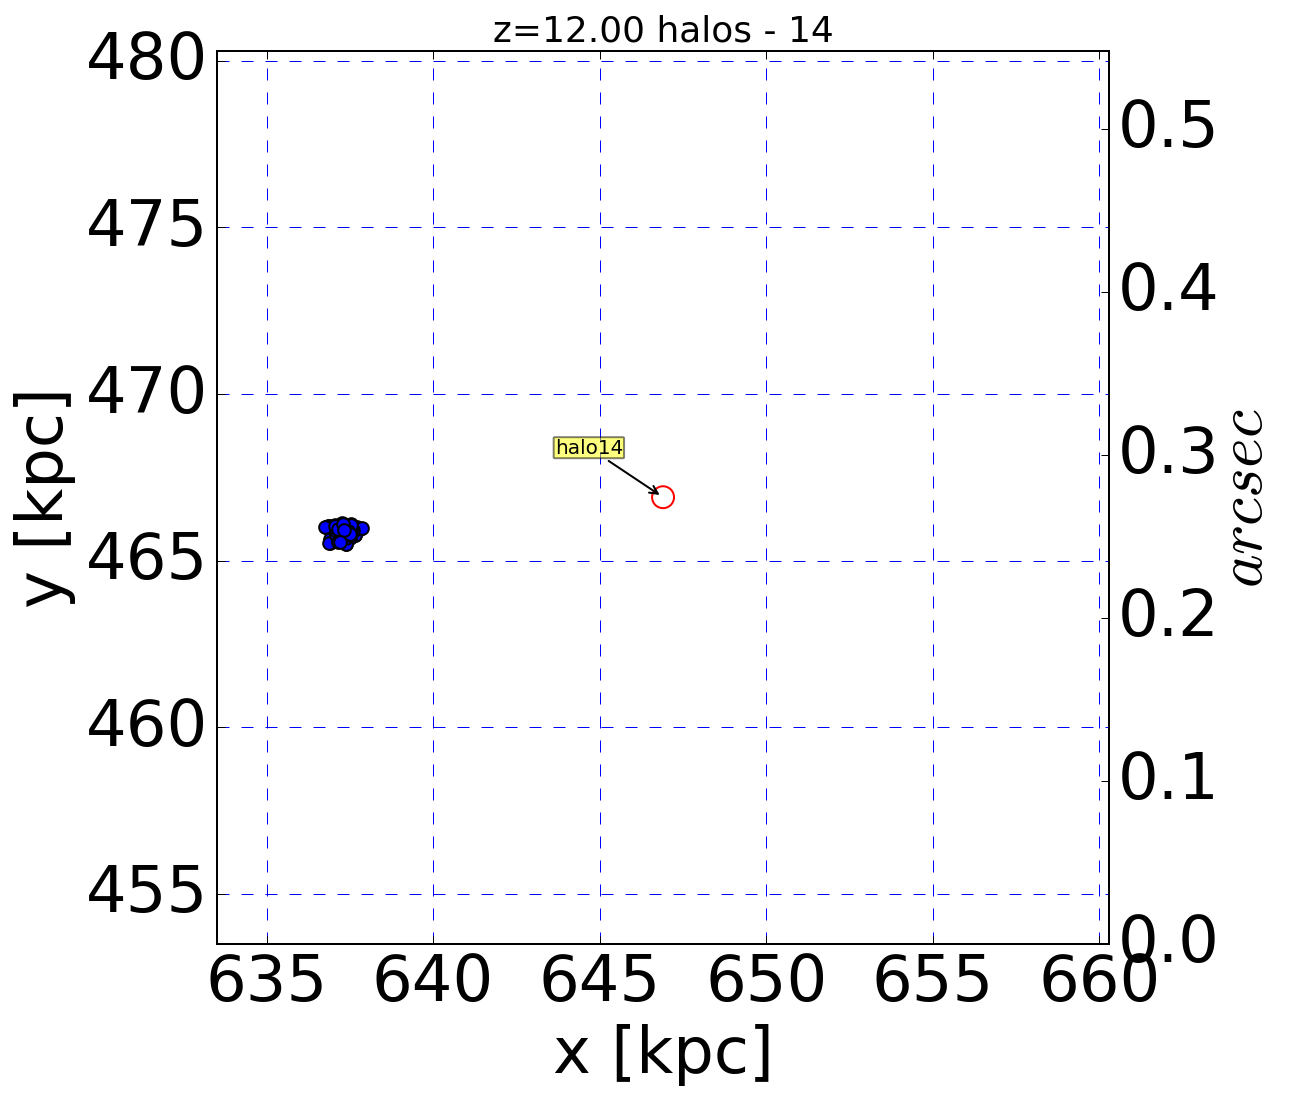

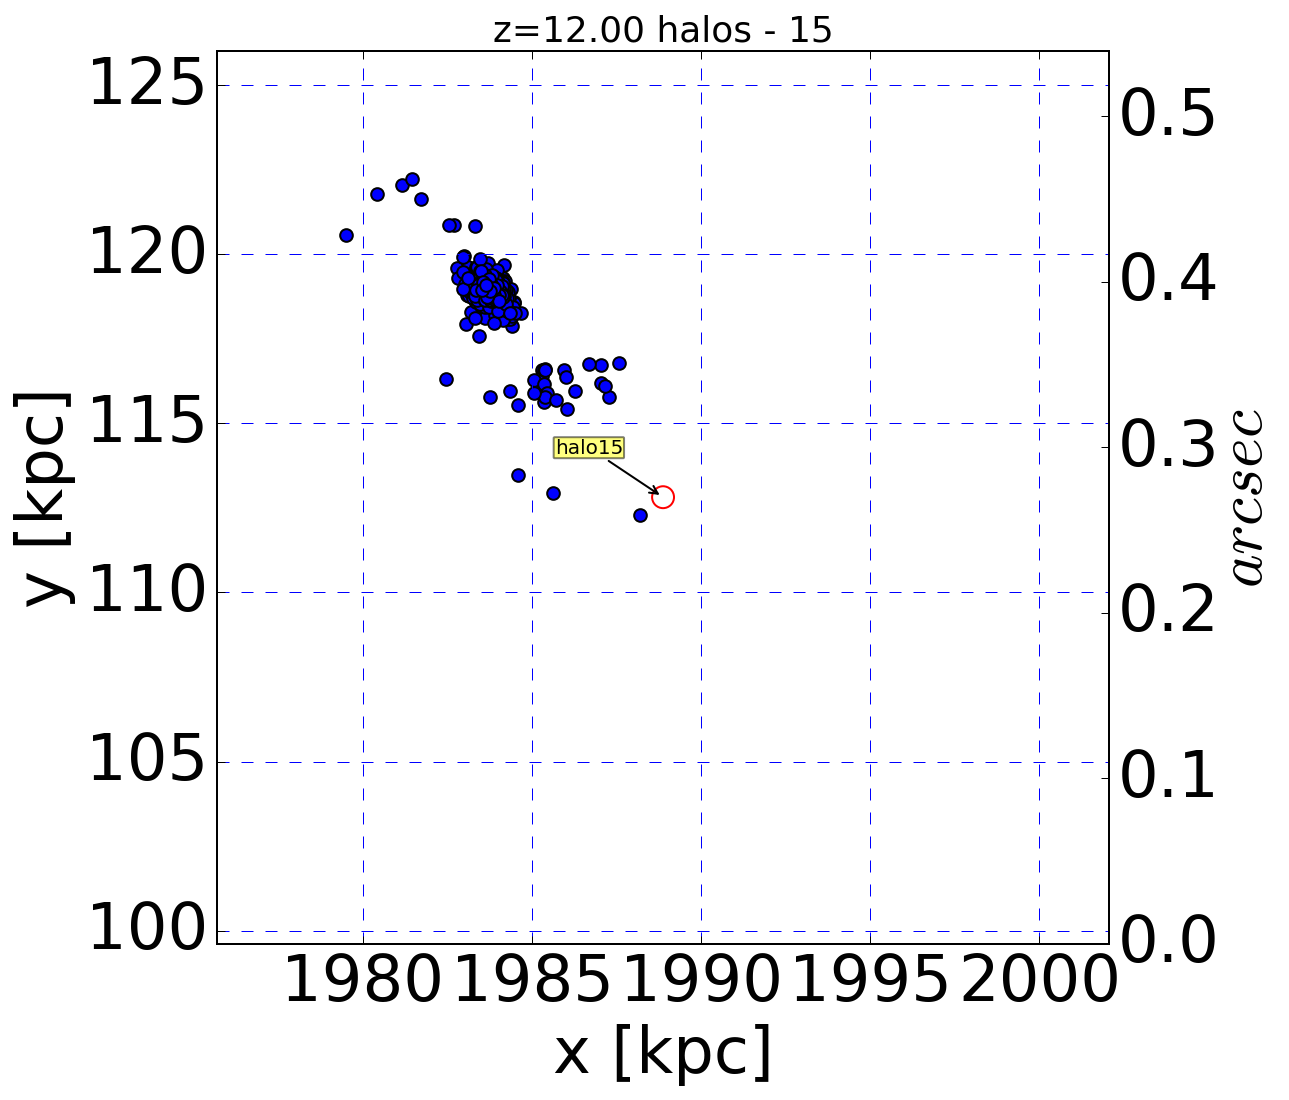

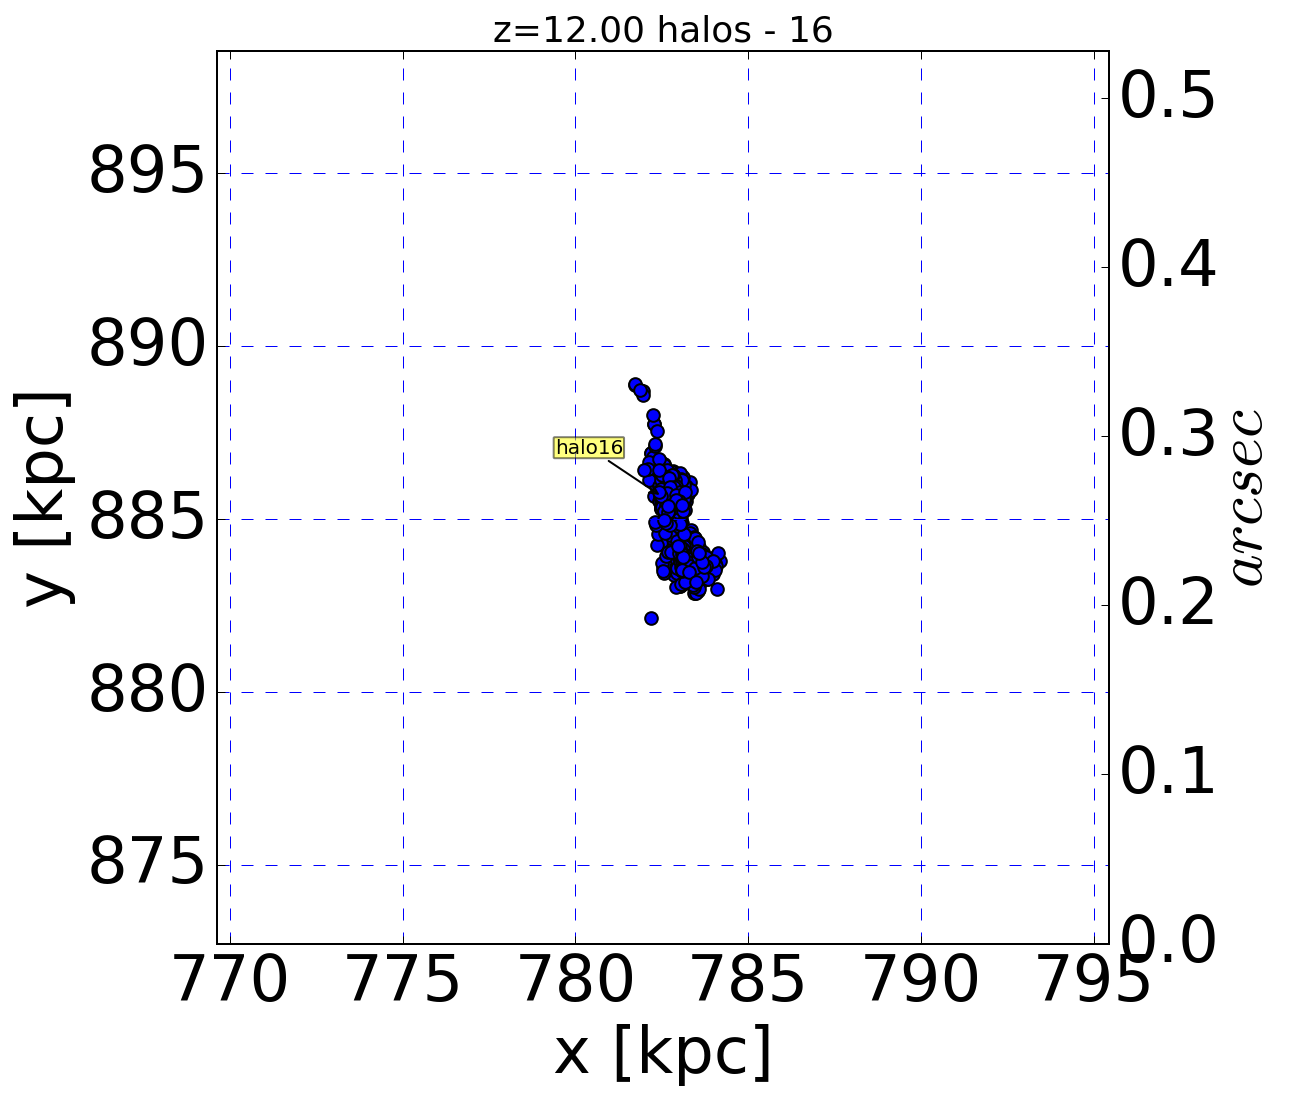

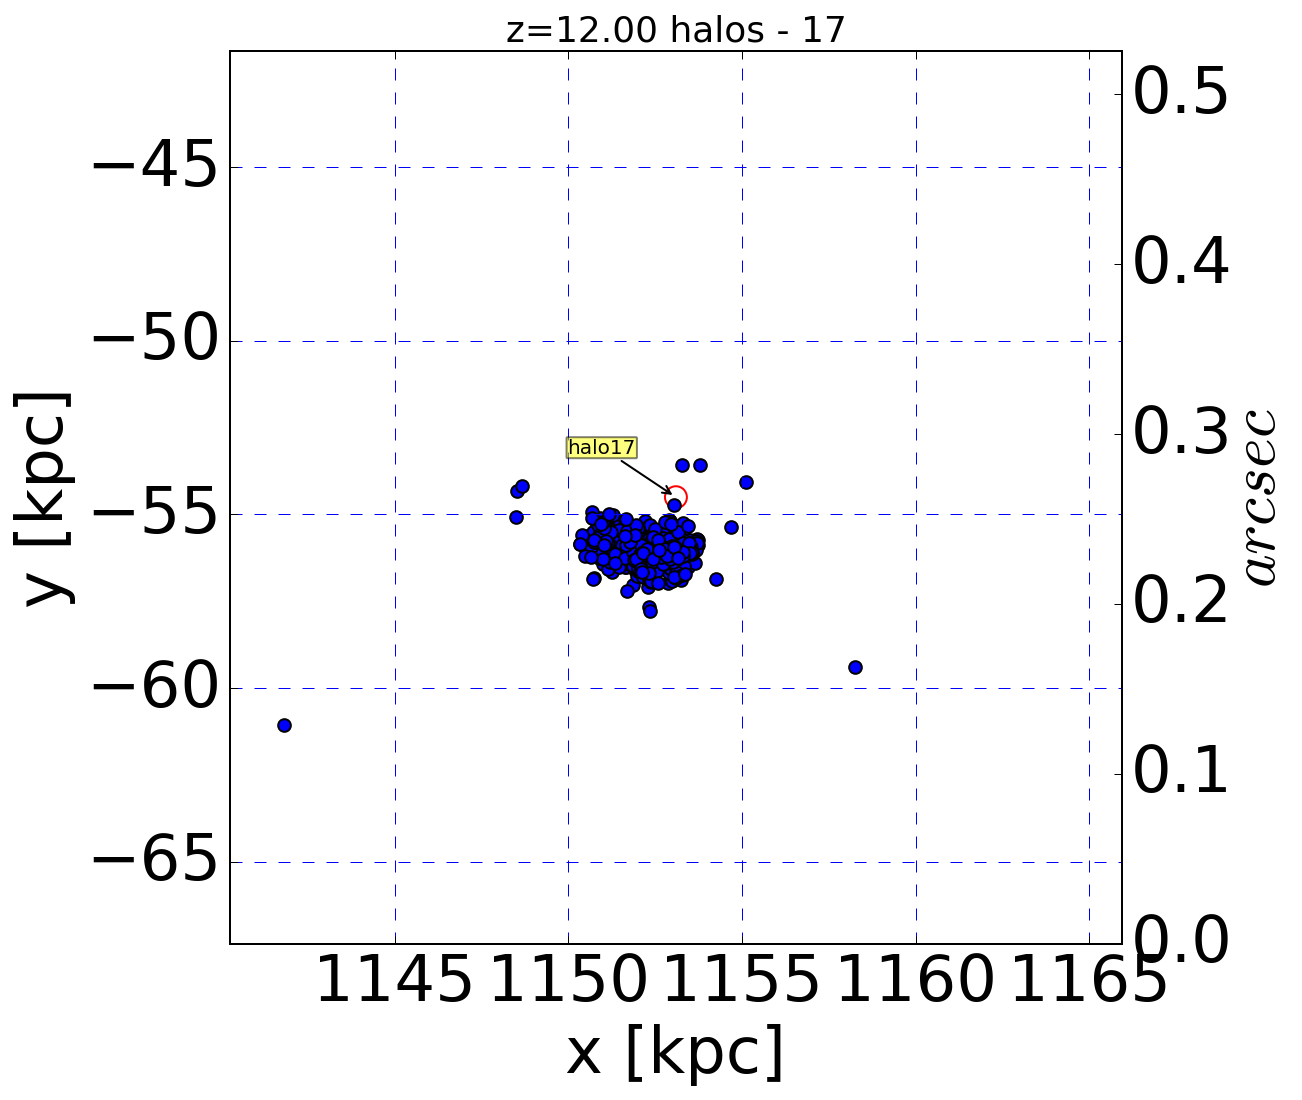

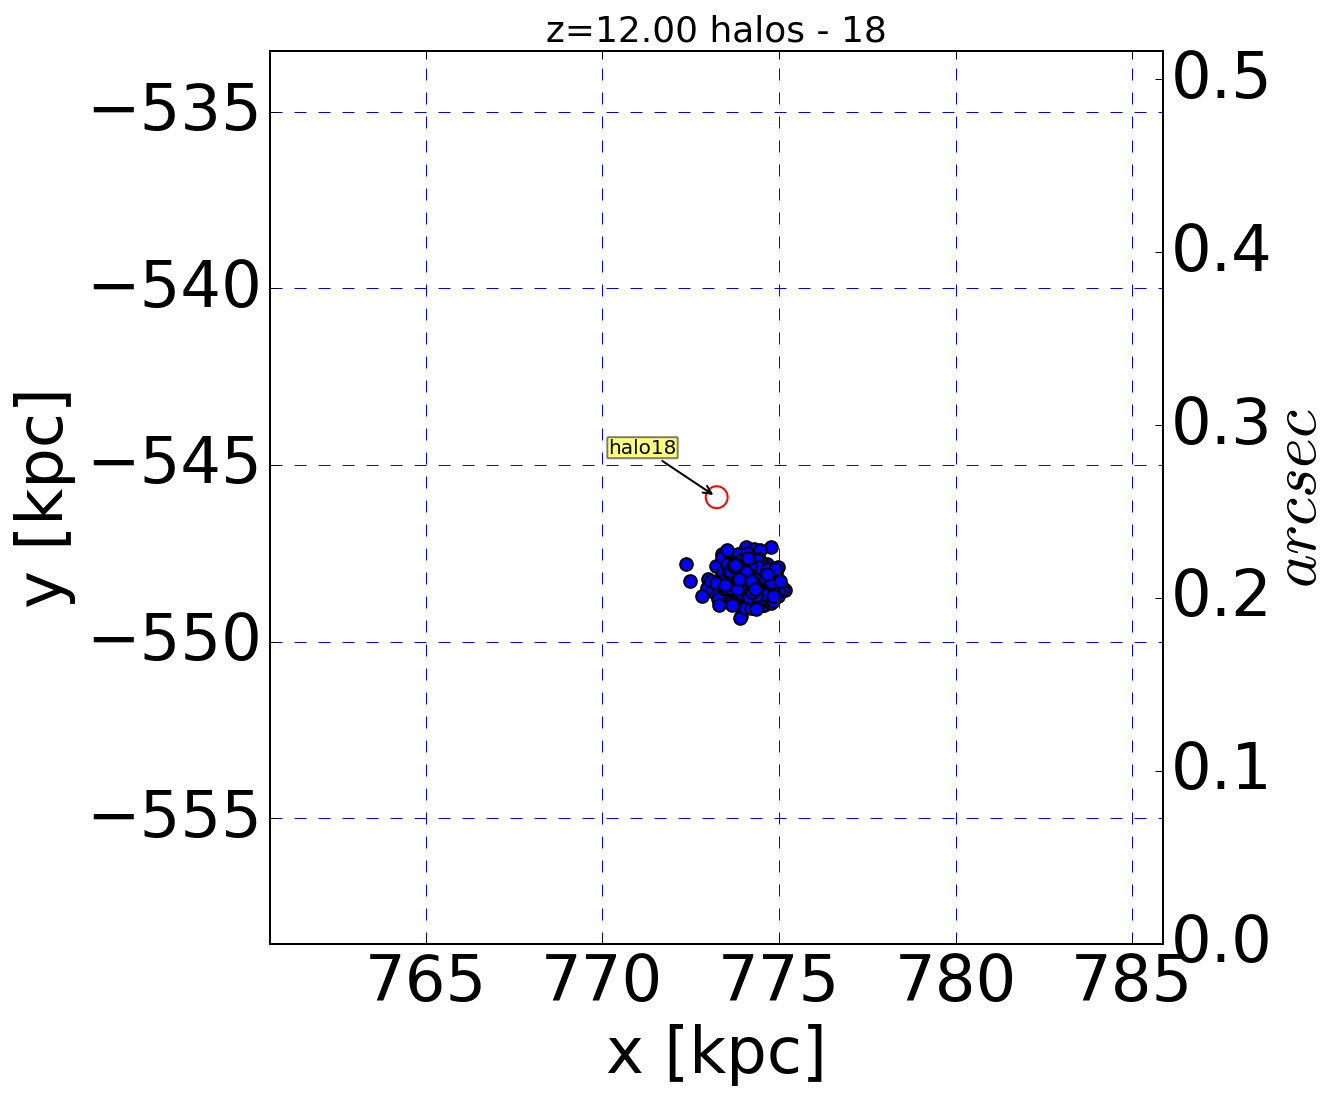

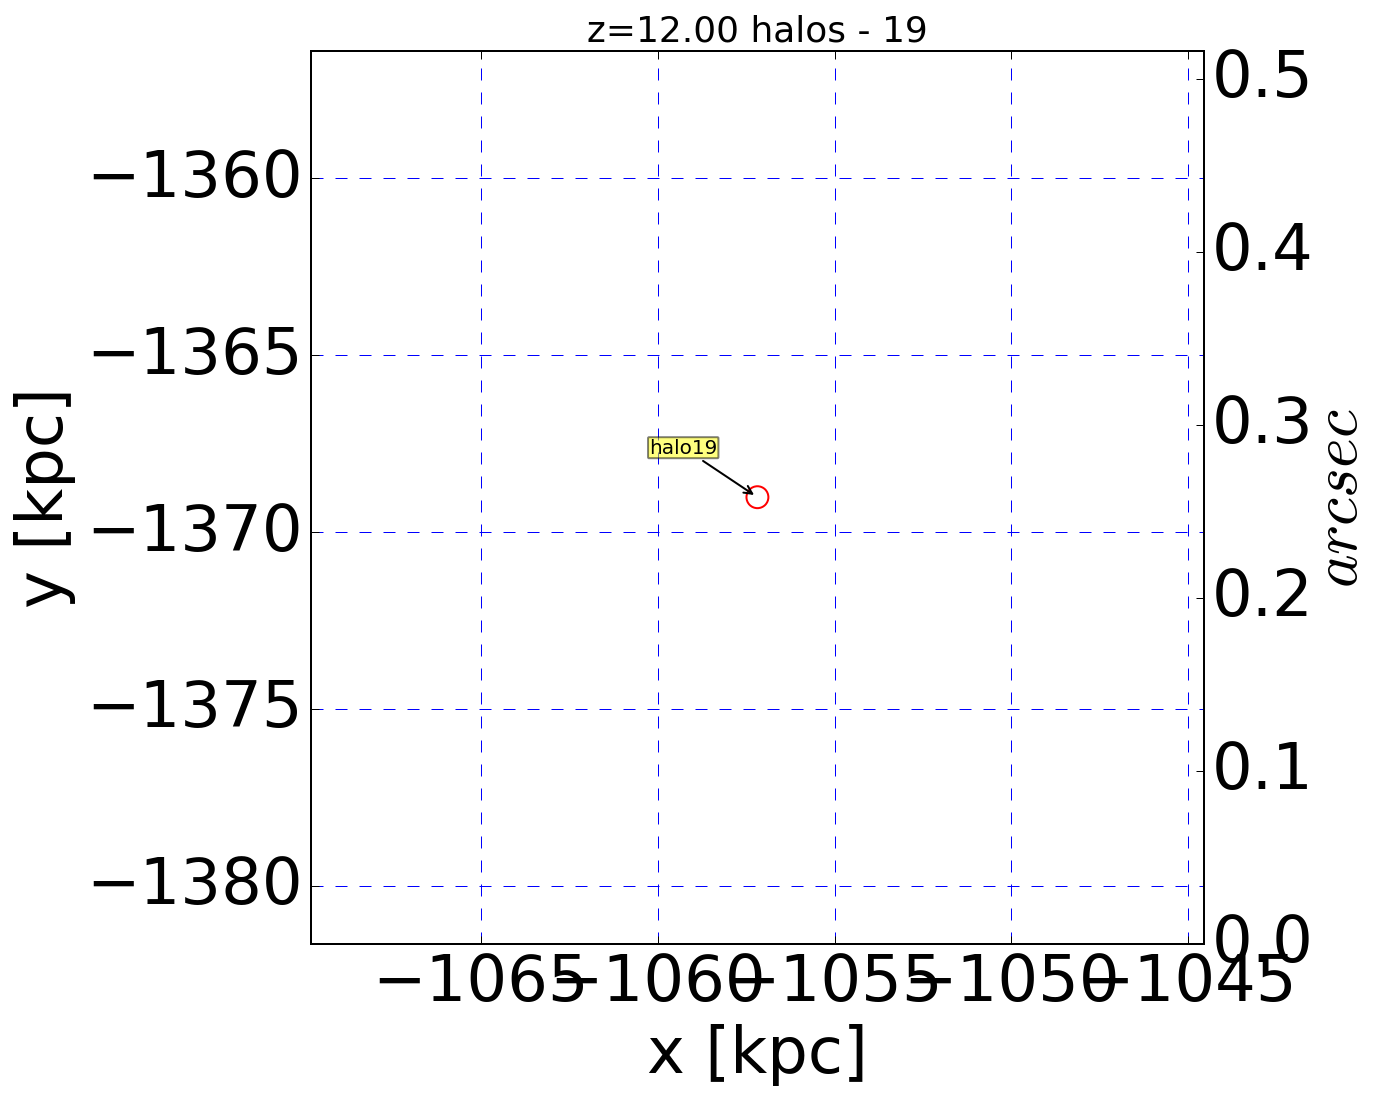

In [31]:
fig = plt.figure(figsize=(8,8))
for halo in range(0,20):
    arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
    radiusScaleFac = 0.750
    radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
               1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * 150 ))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
    radius = radius.value * radiusScaleFac
    print('radius {:.2f}'.format(radius))

    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=radius)

    print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))
    ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    plt.savefig('/Users/earnric/Desktop/DM-galaxy_z_{}_{}.png'.format(z,halo),dpi=fig.dpi,bbox_inches='tight')
    del ax
gc.collect()

z=12.0
radius 25.65
Halo mass 0 is 7.12e+06


IOError: [Errno 2] No such file or directory: '/Volumes/ASU-2TB-Ext/z12.0/galaxy_z_DM_12.0_0.png'

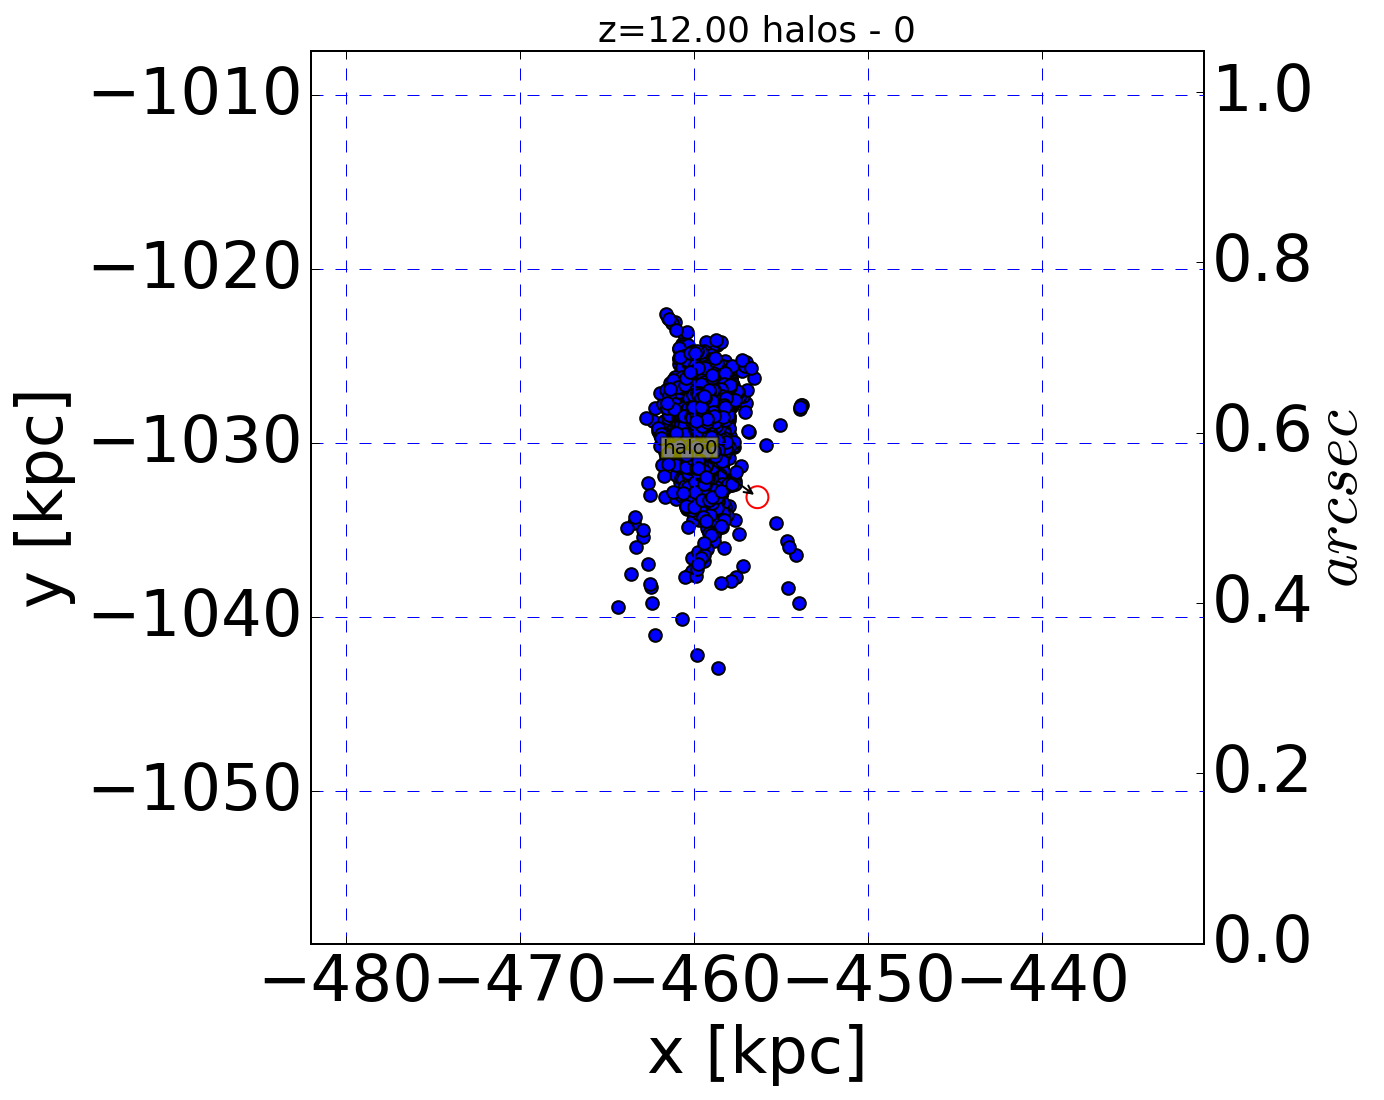

In [26]:
overDens = 100.0
radiusScaleFac = 0.75
print("z={}".format(z))
arcSec_per_kpc_comov = myCosmo.arcsec_per_kpc_comoving(z=z).value 
#for halo in range(len(halosRawPos)):
for halo in range(100):
    # Remember to compute radius in Comoving coords
    #### Remember to be compat with locs, halosPos units ####
    radius = ((totMass(halossizes['count'][halo]) * 3.0/(4.0 * ma.pi) * \
               1.0/(myCosmo.critical_density(z) * myCosmo.Odm(z) * overDens ))**(1.0/3.0)).to(u.kpc) * (1.0 * z)
    radius = radius.value * radiusScaleFac
    print('radius {:.2f}'.format(radius))
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=5)
    if len(halomass) == 0:
        print("SKipping {} since no sps at center...".format(halo))
        continue
    haloStars,halomass,haloages,haloZ,haloPZ,haloPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,halo,r=radius)

    print("Halo mass {} is {:.2e}".format(halo, np.sum(halomass)))
    fig = plt.figure(figsize=(8,8))
    ax=halos.pltView(locs,halosPos,halo,z,radius * 2.0)
    hax2 = ax.twinx()
    hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
    hax2.set_ylabel(r'$arcsec$')
    hax2.yaxis.labelpad = -3
    plt.savefig('/Volumes/ASU-2TB-Ext/z{:.1f}/'.format(z)+'galaxy_z_DM_{}_{}.png'.format(z,halo),dpi=fig.dpi,bbox_inches='tight')
    plt.clf()
    del ax
    gc.collect()

###### ax=halos.pltView(locs,halosPos,9,z,40) # x2 since size is full-fov ... size = 2xradius
hax2 = ax.twinx()
hax2.set_ylim([0,radius * 2.0 * arcSec_per_kpc_comov])
hax2.set_ylabel(r'$arcsec$')
hax2.yaxis.labelpad = -3
gc.collect()